In [2]:
#library(SeuratWrappers)
library(Seurat)
library(patchwork)
library(dplyr)
library(ggplot2)
packageVersion("Seurat")

[1] ‘4.3.0.1’

## Fig7a - Map to reference

#### Prepare for query mapping

In [3]:
ast <- readRDS('../4th_samp_by_hl_500-per-Sample/seurat_harmony_70674x25802.rds')

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 25802 by 70674

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 44 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 25802 genes



  |======================================================================| 100%


Computing corrected count matrix for 25802 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 14.3515 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, SampleName

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  SLC1A2, NRXN1, CACNB2, GPC5, HPSE2, ZNF98, SGCD, CABLES1, RIMS1, RORA 
	   PLCB1, SLC4A4, ARHGAP24, SLC1A3, GRM3, CADM1, LRP1B, GPM6A, LSAMP, AC097518.2 
	   CTNNA2, DNM3, CADM2, LINC00499, AC002069.2, VAV3, SYNE1, ADGRB3, LRRC4C, ZNF804B 
Negative:  DPP10, DCLK1, LINC01088, AC012405.1, TNC, LINC00609, CCDC85A, CD44, SLC38A1, KAZN 
	   GPC6, TSHZ2, ROBO2, AC073941.1, ADAMTSL3, LINC00836, TTN, CPAMD8, IGFBP5, STXBP5L 
	   ADAMTS9-AS2, SNED1, GALNT15, HS6ST3, VCAN, L3MBTL4, PLEKHA5, GALNT13, SYNPO2, CRYAB 
PC_ 2 
Positive:  ELMO1, APBB1IP, DOCK8, LNCAROD, RUNX1, ATP8B4, FYB1, DISC1, SYNDIG1, ADAM28 
	   PLXDC2, SLC8A1, ARHGAP15, DOCK2, IPCEF1, PTPRC, SRGAP2, HS3ST4, SPP1, TMEM163 
	   LINC02232, IKZF1, AL163541.1, AOAH, FOXP2, FMN1

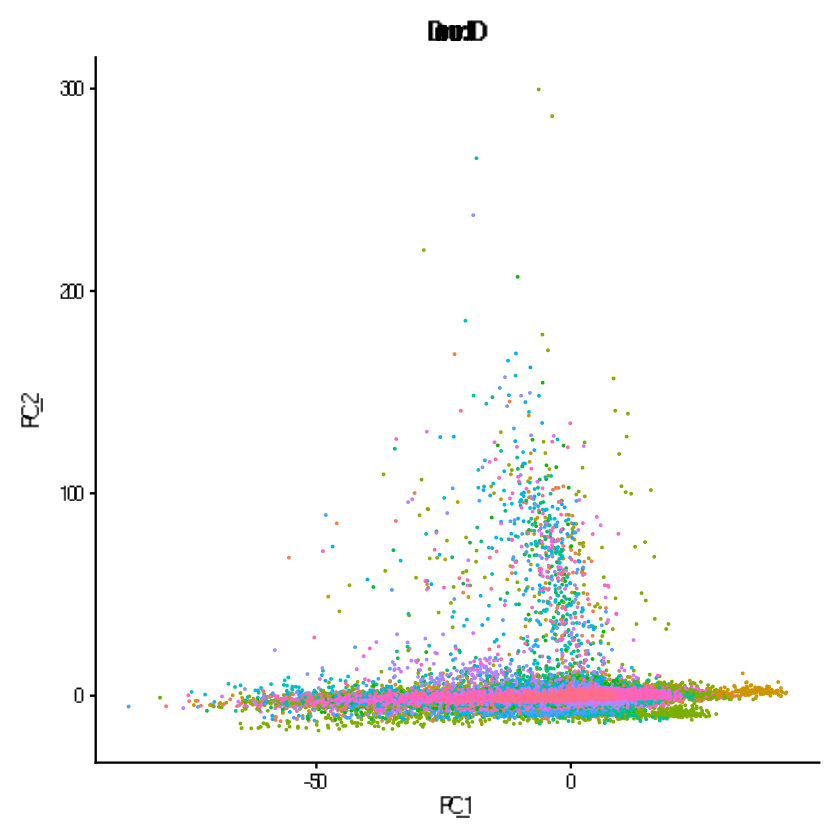

In [4]:
ast_ref = CreateSeuratObject(counts = GetAssayData(ast, assay = 'RNA', slot='counts'),
                             meta.data = ast@meta.data)
ast_ref <- PercentageFeatureSet(ast_ref, pattern = "^MT-", col.name = "percent.mt")
# prep for query mapping
ast_ref = SCTransform(ast_ref, vars.to.regress = c("percent.mt", "SampleName"))
ast_ref = RunPCA(ast_ref)
### use Harmony for UMAP
ast_ref[['harmony']] = ast[['harmony']]
ast_ref = RunUMAP(ast_ref, reduction = "harmony", dims = 1:20, verbose = FALSE, return.model = TRUE) #PCA: dims = 1:30,
DimPlot(ast_ref, group.by = "Donor.ID", label = TRUE, repel = TRUE) + NoLegend()

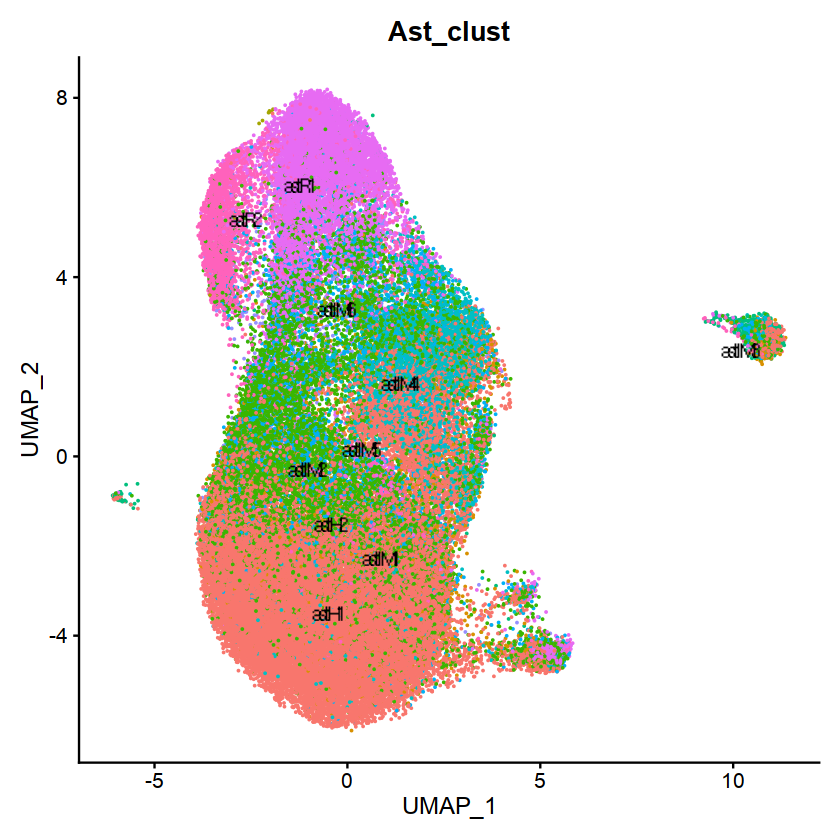

In [5]:
DimPlot(ast_ref, reduction = 'umap', group.by = "Ast_clust", label = TRUE, repel = TRUE) + NoLegend() +
    theme(text=element_text(size=14,  family="Arial")) 

In [10]:
# saveRDS(ast_ref, './ast_resamped_projected.20240228.rds')
ast_ref <- readRDS('./ast_resamped_projected.20240228.rds')
ast_ref

An object of class Seurat 
51604 features across 70674 samples within 2 assays 
Active assay: SCT (25802 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, harmony, umap

#### Dai dataset  
Dai, D.L., Li, M. & Lee, E.B. Human Alzheimer’s disease reactive astrocytes exhibit a loss of homeostastic gene expression. acta neuropathol commun 11, 127 (2023). https://doi.org/10.1186/s40478-023-01624-8

In [6]:
dai_obj <- readRDS('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/Dai/GSE243292_Astrocyte_GEO.rds')
table(dai_obj@meta.data$sampleID)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
 569 1051 1964  426  574 1009 1219 1494 1861 1395  582  852  821  527 1185 

In [ ]:
## subset N per sample
Idents(dai_obj) <- dai_obj@meta.data$sampleID
dai_obj <- subset(dai_obj, downsample = 500) 
dim(dai_obj)

### regress out mito.percent and Sample effect
dai_obj <- PercentageFeatureSet(dai_obj, pattern = "^MT-", col.name = "percent.mt")
summary(dai_obj$percent.mt)

### QC
Idents(dai_obj) <- 'Combined'
VlnPlot(dai_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [8]:
dai_obj = SCTransform(dai_obj, vars.to.regress = c("percent.mt", "sampleID"))
dai_obj = RunPCA(dai_obj, verbose = FALSE)
dai_obj = RunUMAP(dai_obj, reduction = "pca", dims = 1:30, verbose = FALSE)
dai_obj = FindNeighbors(dai_obj, reduction = "pca", dims = 1:30, verbose = FALSE) %>%
                FindClusters(resolution = 0.5, verbose = FALSE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17011 by 7426

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 42 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17011 genes



  |======================================================================| 100%


Computing corrected count matrix for 17011 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.213285 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, sampleID

Centering data matrix

Set default assay to SCT

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [9]:
# transfer
anchors = FindTransferAnchors(reference = ast_ref, query = dai_obj, dims = 1:30, 
                              reference.reduction = "pca", normalization.method = "SCT")
predictions = TransferData(anchorset = anchors, refdata = ast_ref$seurat_clusters, dims = 1:30) #"Ast_clust"

dai_obj = MapQuery(anchorset = anchors, reference = ast_ref, query = dai_obj, 
                    refdata = "seurat_clusters", #"Ast_clust"
                    reference.reduction = "pca", reduction.model = "umap")

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 6437 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”
Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

21:36:51 Read 7426 rows

21:36:51 Processing block 1 of 1

21:36:51 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:36:51 Initializing by weighted average of neighbor coordinates using 1 thread

21:36:51 Commencing optimization for 67 epochs, with 222780 positive edges

21:36:52 Finished



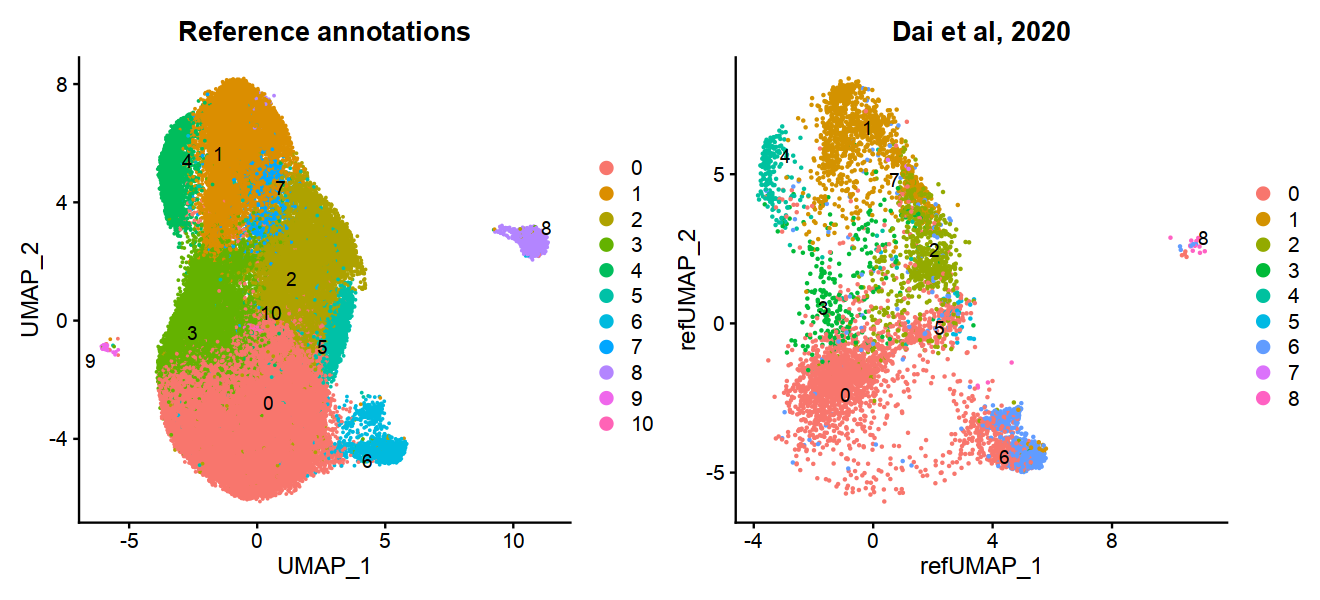

In [10]:
p1 = DimPlot(ast_ref, reduction = "umap", group.by = "seurat_clusters", repel = TRUE) + 
        ggtitle("Reference annotations") + 
        theme(text=element_text(size=14,  family="Arial")) 
p2 = DimPlot(dai_obj, reduction = "ref.umap", group.by = "predicted.id", repel = TRUE) + 
        ggtitle("Dai et al, 2020") + #paste0("Dai et al, 2023 (N = ", dim(dai_obj)[2], ")")
        theme(text=element_text(size=14,  family="Arial")) 

options(repr.plot.height = 5, repr.plot.width = 11)
LabelClusters(plot=p1, id = 'seurat_clusters', size = 4, family='Arial') + 
LabelClusters(p2, id = 'predicted.id', size = 4, family='Arial')

In [17]:
# saveRDS(dai_obj, "dai_projected_2ast-resamped.to-1-2-3.20240228.rds")

#### Lau dataset

In [11]:
library(AnnotationDbi)
library(org.Hs.eg.db)
# keytypes(org.Hs.eg.db)

In [12]:
load('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/Lau/Lau-raw.Rdata')
ls()

[1] "ast"          "ast_ref"      "lau"          "var_dic_list"

In [19]:
ensemblID_to_symbol <- as.data.frame(mapIds(org.Hs.eg.db, 
                           keys=rownames(lau), 
                           column='SYMBOL', 
                           keytype="ENSEMBL",
                           multiVals="first"))
colnames(ensemblID_to_symbol) <- 'symbol'
ensemblID_to_symbol$ENSEMBL <- rownames(ensemblID_to_symbol)
ensemblID_to_symbol <- ensemblID_to_symbol[complete.cases(ensemblID_to_symbol$symbol),]

'select()' returned 1:many mapping between keys and columns



In [20]:
lau_count <-  GetAssayData(lau, assay = 'RNA', slot = 'counts')
lau_count <- lau_count[ensemblID_to_symbol$ENSEMBL, ]
rownames(lau_count) <- ensemblID_to_symbol$symbol

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


[1] 20065 20066

[1] 20065  8831

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


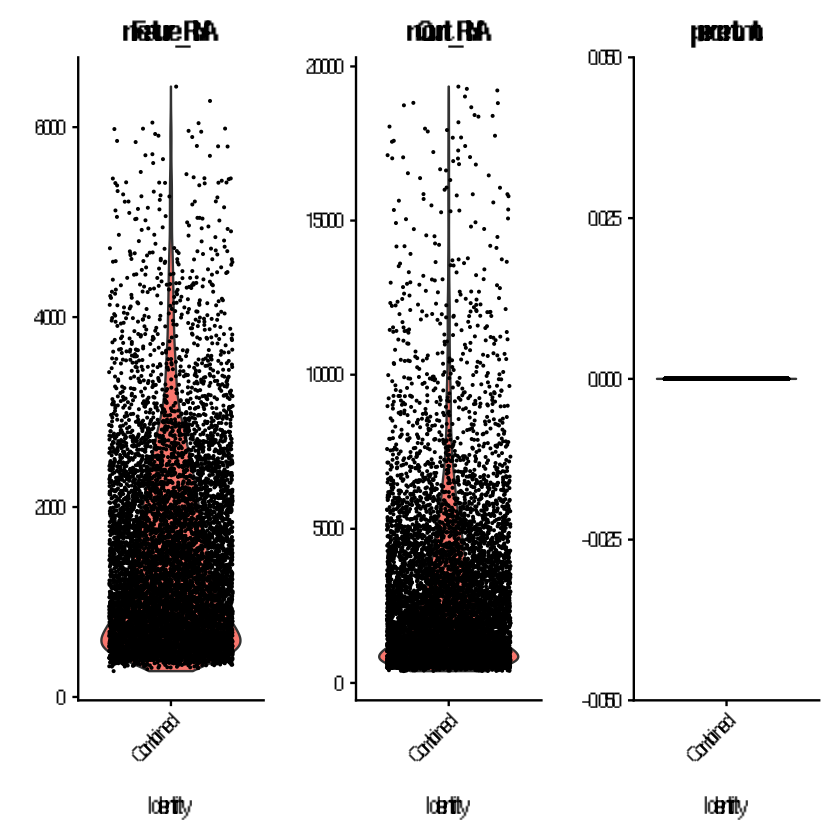

In [21]:
lau_obj <- CreateSeuratObject(counts = lau_count, 
                              meta.data = lau@meta.data, 
                              project = "Lau", min.cells = 20)
### subset only astrocyte
lau_obj <- lau_obj[,lau_obj$celltype == 'astrocytes']
dim(lau_obj)

## subset N per sample
Idents(lau_obj) <- lau_obj@meta.data$Donor.ID
lau_obj <- subset(lau_obj, downsample = 500) 
dim(lau_obj)

### regress out mito.percent and Sample effect
lau_obj <- PercentageFeatureSet(lau_obj, pattern = "^MT-", col.name = "percent.mt")
summary(lau_obj$percent.mt)

### QC
Idents(lau_obj) <- 'Combined'
VlnPlot(lau_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [22]:
lau_obj = SCTransform(lau_obj, vars.to.regress = c("Donor.ID"))
lau_obj = RunPCA(lau_obj, verbose = FALSE)
lau_obj = RunUMAP(lau_obj, reduction = "pca", dims = 1:30, verbose = FALSE)
lau_obj = FindNeighbors(lau_obj, reduction = "pca", dims = 1:30, verbose = FALSE) %>%
                FindClusters(resolution = 0.5, verbose = FALSE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17923 by 8831

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 85 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17923 genes



  |======================================================================| 100%


Computing corrected count matrix for 17923 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.79478 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out Donor.ID

Centering data matrix

Set default assay to SCT



In [24]:
#transfer
anchors = FindTransferAnchors(reference = ast_ref, query = lau_obj, dims = 1:30, 
                              reference.reduction = "pca", normalization.method = "SCT")
predictions = TransferData(anchorset = anchors, refdata = ast_ref$seurat_clusters, dims = 1:30) #Ast_clust

lau_obj = MapQuery(anchorset = anchors, reference = ast_ref, query = lau_obj, 
                   refdata = "seurat_clusters",  #Ast_clust
                   reference.reduction = "pca", reduction.model = "umap")

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 10987 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”
Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

22:04:25 Read 8831 rows

22:04:25 Processing block 1 of 1

22:04:25 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:04:25 Initializing by weighted average of neighbor coordinates using 1 thread

22:04:25 Commencing optimization for 67 epochs, with 264930 positive edges

22:04:26 Finished



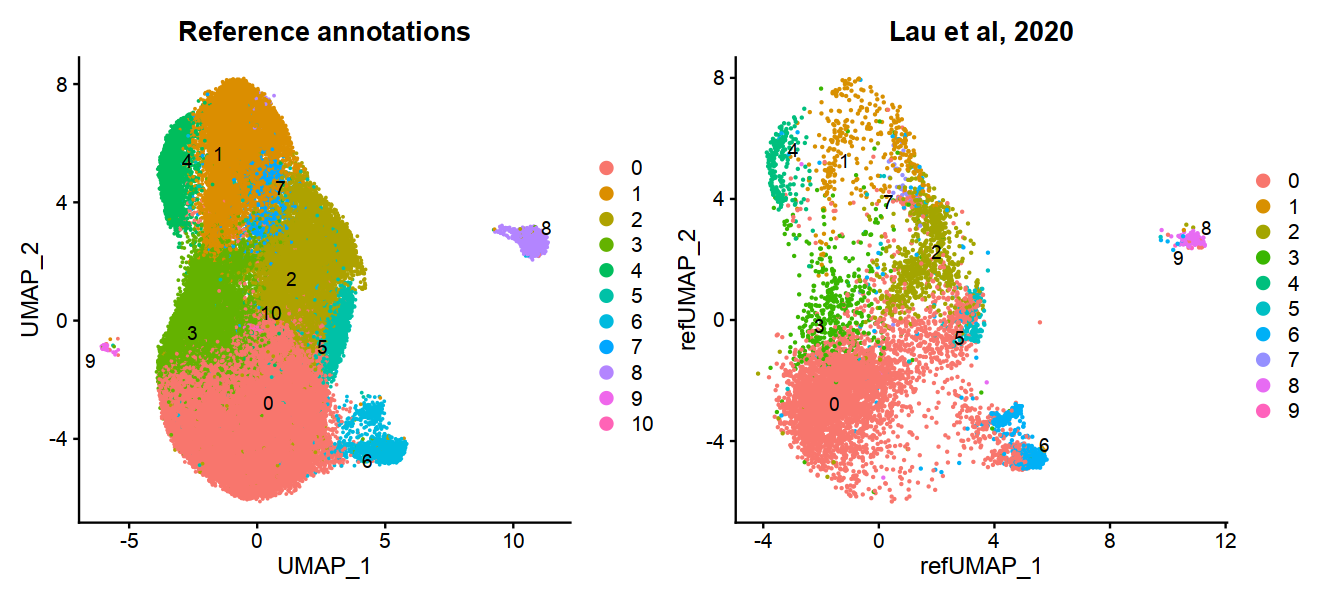

In [25]:
p1 = DimPlot(ast_ref, reduction = "umap", group.by = "seurat_clusters", repel = TRUE) + 
        ggtitle("Reference annotations") + 
        theme(text=element_text(size=14,  family="Arial")) 
p2 = DimPlot(lau_obj, reduction = "ref.umap", group.by = "predicted.id", repel = TRUE) + 
        ggtitle("Lau et al, 2020") + #paste0("Lau et al, 2020 (N = ", dim(lau_obj)[2], ")")
        theme(text=element_text(size=14,  family="Arial")) 

options(repr.plot.height = 5, repr.plot.width = 11)
LabelClusters(plot=p1, id = 'seurat_clusters', size = 4, family='Arial') + 
LabelClusters(p2, id = 'predicted.id', size = 4, family='Arial')

In [26]:
# saveRDS(lau_obj, "lau_projected_2ast-resamped.to-1-2-3.20240228.rds")

#### Leng dataset

In [28]:
library(SingleCellExperiment)

In [29]:
leng_ec <- readRDS('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/Leng/sce.EC.Astro.scAlign.rds')
leng_sfg <- readRDS('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/Leng/sce.SFG.Astro.scAlign.rds')

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


[1] 20

[1] 18998 11470

[1] 18998  8165

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2225  0.7968  1.2524  1.7804 28.4899 

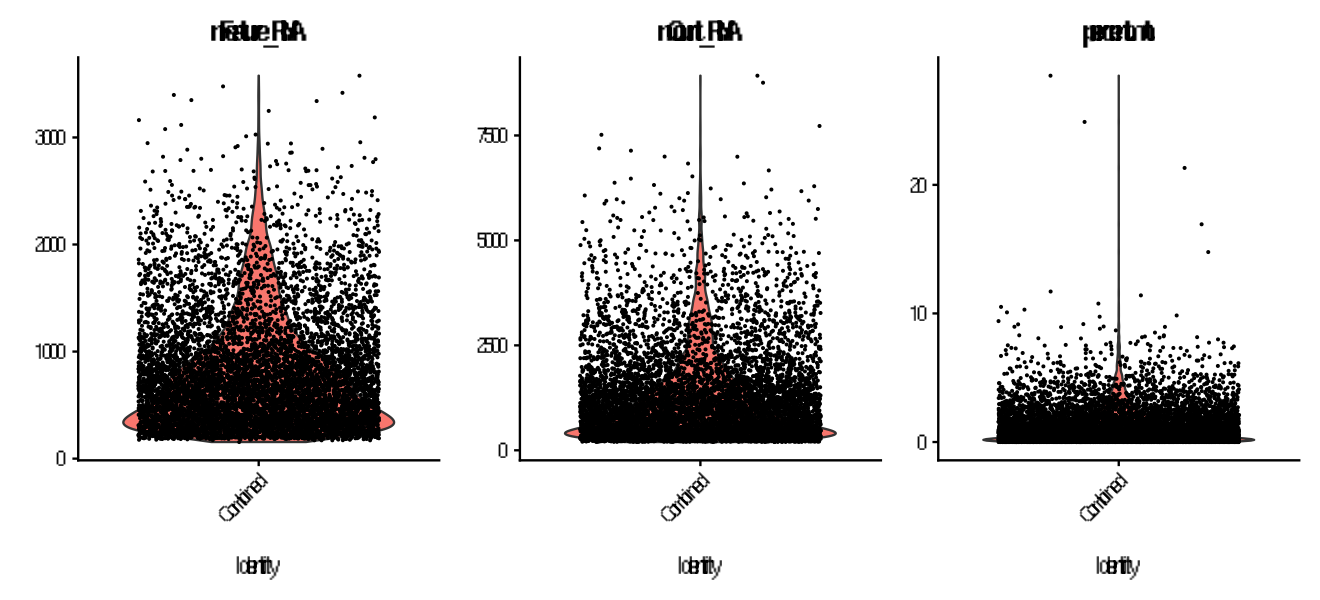

In [31]:
leng_obj <- CreateSeuratObject(counts = cbind(counts(leng_sfg), counts(leng_ec)),
                               meta.data = as.data.frame(rbind(colData(leng_sfg), colData(leng_ec))),
                              project = "Leng", min.cells = 20)
length(unique(leng_obj$SampleID))
dim(leng_obj)

### subset N per sample
Idents(leng_obj) <- leng_obj@meta.data$SampleID
leng_obj <- subset(leng_obj, downsample = 500) 
dim(leng_obj)

### regress out mito.percent and Sample effect
leng_obj <- PercentageFeatureSet(leng_obj, pattern = "^MT-", col.name = "percent.mt")
summary(leng_obj$percent.mt)

### QC
Idents(leng_obj) <- 'Combined'
VlnPlot(leng_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [32]:
### nFeature_RNA: the number of genes detected in each cell
dim(leng_obj)
leng_obj <- subset(leng_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 5)
dim(leng_obj)

[1] 18998  8165

[1] 18998  7783

In [33]:
leng_obj = SCTransform(leng_obj, vars.to.regress = c("percent.mt", "SampleID"))
leng_obj = RunPCA(leng_obj, verbose = FALSE)
leng_obj = RunUMAP(leng_obj, reduction = "pca", dims = 1:30, verbose = FALSE)
leng_obj = FindNeighbors(leng_obj, reduction = "pca", dims = 1:30, verbose = FALSE) %>%
                FindClusters(resolution = 0.5, verbose = FALSE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18998 by 7783

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 27 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18998 genes



  |======================================================================| 100%


Computing corrected count matrix for 18998 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.250987 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, SampleID

Centering data matrix

Set default assay to SCT



In [35]:
#transfer
anchors = FindTransferAnchors(reference = ast_ref, query = leng_obj, dims = 1:30, 
                              reference.reduction = "pca", normalization.method = "SCT")
predictions = TransferData(anchorset = anchors, refdata = ast_ref$seurat_clusters, dims = 1:30) #"Ast_clust"

leng_obj = MapQuery(anchorset = anchors, reference = ast_ref, query = leng_obj, 
                    refdata = "seurat_clusters", #"Ast_clust"
                    reference.reduction = "pca", reduction.model = "umap")

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 4433 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

22:13:23 Read 7783 rows

22:13:23 Processing block 1 of 1

22:13:23 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:13:23 Initializing by weighted average of neighbor coordinates using 1 thread

22:13:23 Commencing optimization for 67 epochs, with 233490 positive edges

22:13:24 Finished



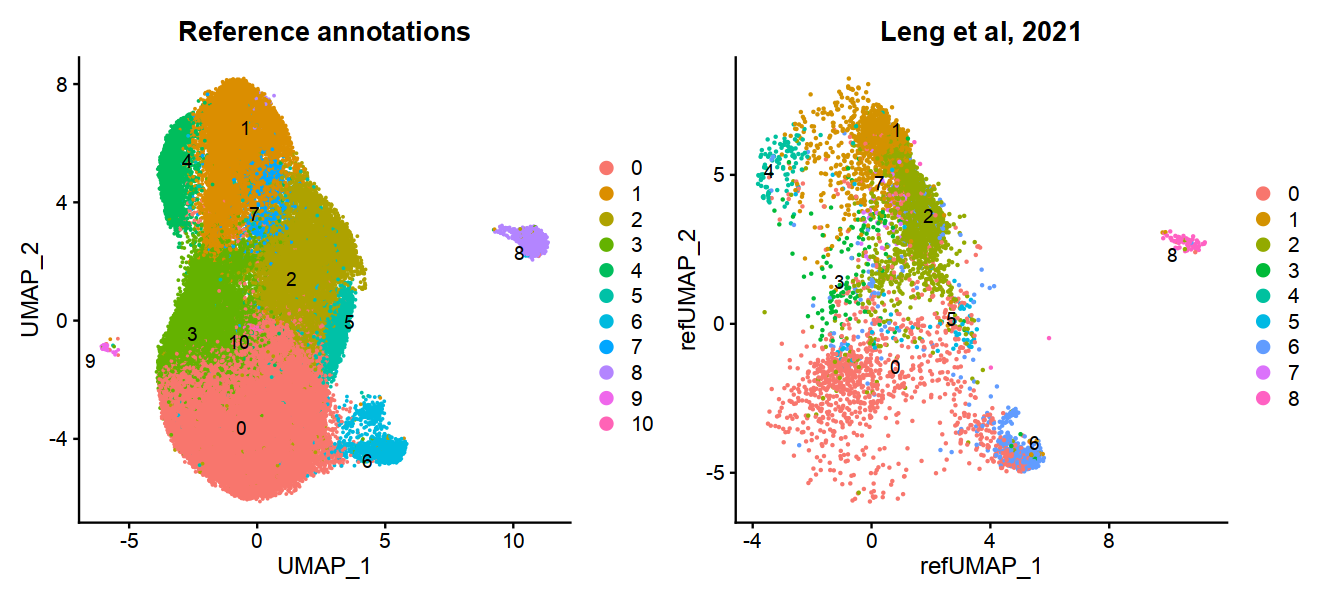

In [37]:
p1 = DimPlot(ast_ref, reduction = "umap", group.by = "seurat_clusters", repel = TRUE) + 
        ggtitle("Reference annotations") + 
        theme(text=element_text(size=14,  family="Arial")) 
p2 = DimPlot(leng_obj, reduction = "ref.umap", group.by = "predicted.id", repel = TRUE) + 
        ggtitle("Leng et al, 2021") + #paste0("Leng et al, 2021 (N = ", dim(leng_obj)[2], ")")
        theme(text=element_text(size=14,  family="Arial")) 

options(repr.plot.height = 5, repr.plot.width = 11)
LabelClusters(plot=p1, id = "seurat_clusters", size = 4, family='Arial') + 
LabelClusters(p2, id = 'predicted.id', size = 4, family='Arial')

In [38]:
# saveRDS(leng_obj, "leng_projected_to_ast-resamped.to-1-2-3.20240228.rds")

#### Smith dataset

In [39]:
load('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/Smith/smith.Rdata')

In [40]:
smith_meta <- readRDS('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/Smith/datalens/smith_meta.rds')
smith_meta <- as.data.frame(smith_meta)
rownames(smith_meta) <- smith_meta$sampleID

[1] 30373 53983

[1] 30373 12000

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2273  0.5431  0.9072  1.2231  4.9945 

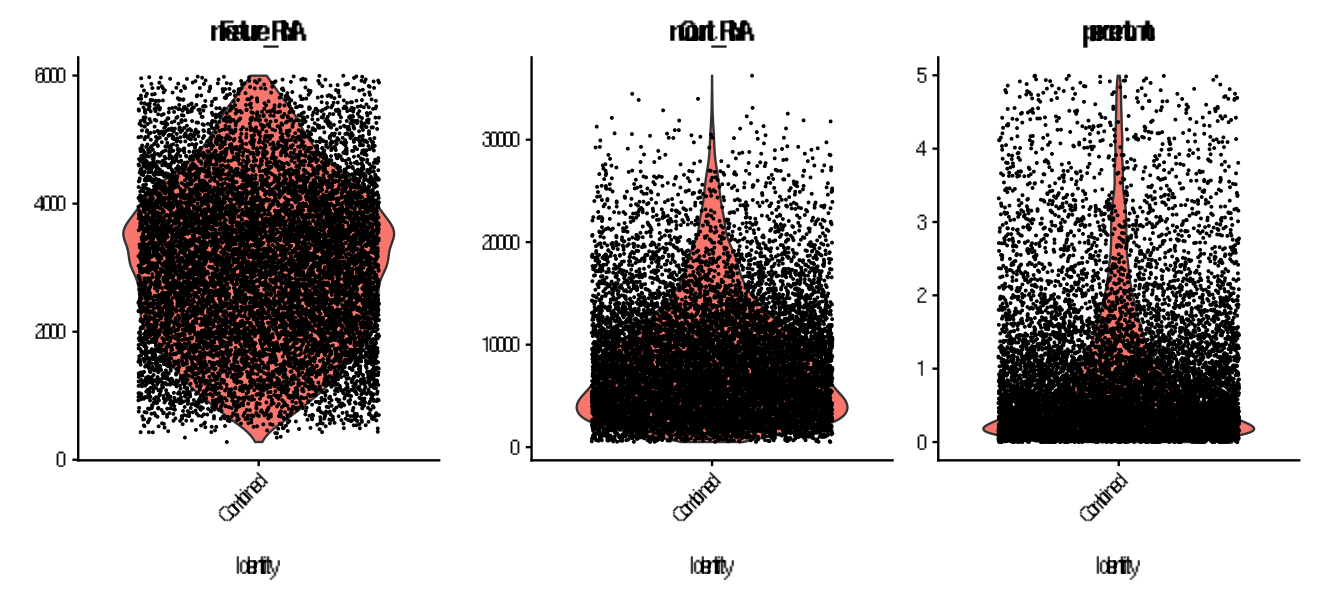

In [41]:
smith_cells = rownames(smith_meta)[rownames(smith_meta) %in% colnames(immune.combined)]
smith <- CreateSeuratObject(counts = GetAssayData(immune.combined[,smith_cells], 
                                                  assay = 'RNA', slot = 'counts'),
                            meta.data = smith_meta[smith_cells,],
                            min.cells = 20)
### subset only astrocyte
smith <- smith[,smith$celltype == 'Astrocytes']
dim(smith)

### subset N per sample
Idents(smith) <- smith@meta.data$name_seurat
smith <- subset(smith, downsample = 500) 
dim(smith)

### regress out mito.percent and Sample effect
smith <- PercentageFeatureSet(smith, pattern = "^MT-", col.name = "percent.mt")
summary(smith$percent.mt)
### QC
Idents(smith) <- 'Combined'
VlnPlot(smith, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [42]:
smith = SCTransform(smith, vars.to.regress = c("percent.mt", "name_seurat"))
smith = RunPCA(smith, verbose = FALSE)
smith = RunUMAP(smith, reduction = "pca", dims = 1:30, verbose = FALSE)
smith = FindNeighbors(smith, reduction = "pca", dims = 1:30, verbose = FALSE) %>%
          FindClusters(resolution = 0.5, verbose = FALSE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 28398 by 12000

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 53 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 28398 genes



  |======================================================================| 100%


Computing corrected count matrix for 28398 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 3.154753 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, name_seurat

Centering data matrix

Set default assay to SCT



In [44]:
#transfer
anchors = FindTransferAnchors(reference = ast_ref, query = smith, dims = 1:30, 
                              reference.reduction = "pca", normalization.method = "SCT")
predictions = TransferData(anchorset = anchors, refdata = ast_ref$seurat_clusters, dims = 1:30) #Ast_clust

smith = MapQuery(anchorset = anchors, reference = ast_ref, query = smith, 
                 refdata = "seurat_clusters",  #"Ast_clust"
                 reference.reduction = "pca", reduction.model = "umap")

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 21635 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

22:24:09 Read 12000 rows

22:24:09 Processing block 1 of 1

22:24:09 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

22:24:09 Initializing by weighted average of neighbor coordinates using 1 thread

22:24:09 Commencing optimization for 67 epochs, with 360000 positive edges

22:24:11 Finished



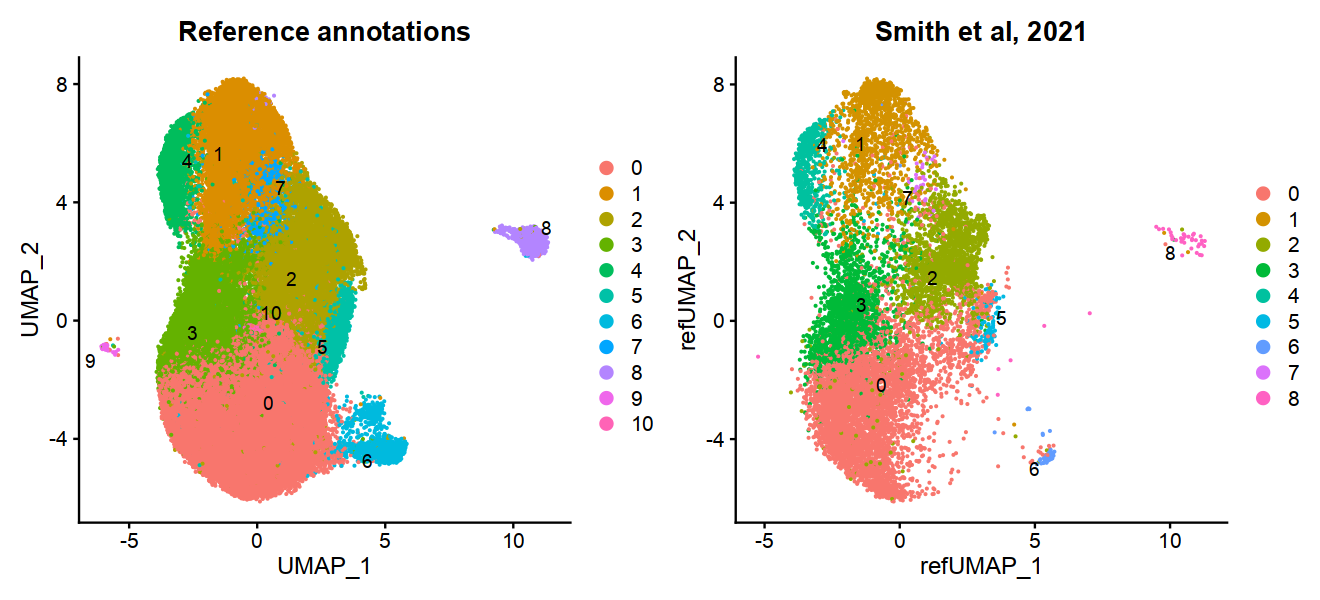

In [45]:
p1 = DimPlot(ast_ref, reduction = "umap", group.by = "seurat_clusters", repel = TRUE, pt.size = 0.1) + 
        ggtitle("Reference annotations") + 
        theme(text=element_text(size=14,  family="Arial")) 
p2 = DimPlot(smith, reduction = "ref.umap", group.by = "predicted.id", repel = TRUE, pt.size = 0.1) + 
        ggtitle("Smith et al, 2021") + #paste0("Smith et al, 2021 (N = ", dim(smith)[2], ")")
        theme(text=element_text(size=14,  family="Arial")) 

options(repr.plot.height = 5, repr.plot.width = 11)
LabelClusters(plot=p1, id = "seurat_clusters", size = 4, family='Arial') + 
LabelClusters(p2, id = 'predicted.id', size = 4, family='Arial')

In [46]:
# saveRDS(smith, "smith_projected_to_ast-resamped.to-1-2-3.20240228.rds")

#### SEA-AD

In [47]:
seaAD_pfc <- readRDS('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/SEA_AD/Astrocyte_DLPFC.rds')
seaAD_mtg <- readRDS('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/SEA_AD/Astrocyte_MTG.rds')

In [48]:
seaAD_counts <- cbind(GetAssayData(seaAD_pfc, assay='RNA', slot='counts'),
                      GetAssayData(seaAD_mtg, assay='RNA', slot='counts'))
dim(seaAD_counts)

[1]  36517 157453

In [49]:
ensemblID_to_symbol <- as.data.frame(mapIds(org.Hs.eg.db, 
                           keys=rownames(seaAD_counts), 
                           column='SYMBOL', 
                           keytype="ENSEMBL",
                           multiVals="first"))
colnames(ensemblID_to_symbol) <- 'symbol'
ensemblID_to_symbol$ENSEMBL <- rownames(ensemblID_to_symbol)
ensemblID_to_symbol <- ensemblID_to_symbol[complete.cases(ensemblID_to_symbol$symbol),]

'select()' returned 1:many mapping between keys and columns



In [50]:
seaAD_counts <- seaAD_counts[ensemblID_to_symbol$ENSEMBL, ]
rownames(seaAD_counts) <- ensemblID_to_symbol$symbol
dim(seaAD_counts)

[1]  23799 157453

In [51]:
cols <- colnames(seaAD_pfc@meta.data)
cols <- cols[cols %in% colnames(seaAD_mtg@meta.data)]
cols

[1] "assay_ontology_term_id"                  
 [2] "suspension_type"                         
 [3] "cell_type_ontology_term_id"              
 [4] "development_stage_ontology_term_id"      
 [5] "disease_ontology_term_id"                
 [6] "self_reported_ethnicity_ontology_term_id"
 [7] "organism_ontology_term_id"               
 [8] "sex_ontology_term_id"                    
 [9] "tissue_ontology_term_id"                 
[10] "is_primary_data"                         
[11] "donor_id"                                
[12] "Neurotypical reference"                  
[13] "Class"                                   
[14] "Subclass"                                
[15] "Supertype"                               
[16] "Age at death"                            
[17] "Years of education"                      
[18] "Cognitive status"                        
[19] "ADNC"                                    
[20] "Braak stage"                             
[21] "Thal phase"                              
[22] "CERAD score"                             
[23] "APOE4 status"                            
[24] "Lewy body disease pathology"             
[25] "LATE-NC stage"                           
[26] "Microinfarct pathology"                  
[27] "Specimen ID"                             
[28] "PMI"                                     
[29] "Number of UMIs"                          
[30] "Genes detected"                          
[31] "Fraction mitochrondrial UMIs"            
[32] "tissue_type"                             
[33] "cell_type"                               
[34] "assay"                                   
[35] "disease"                                 
[36] "organism"                                
[37] "sex"                                     
[38] "tissue"                                  
[39] "self_reported_ethnicity"                 
[40] "development_stage"                       
[41] "observation_joinid"

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is assay_ontology_term_idsuspension_typecell_type_ontology_term_iddevelopment_stage_ontology_term_iddisease_ontology_term_idself_reported_ethnicity_ontology_term_idorganism_ontology_term_idsex_ontology_term_idtissue_ontology_term_idis_primary_datadonor_idNeurotypical.referenceClassSubclassSupertypeAge.at.deathYears.of.educationCognitive.statusADNCBraak.stageThal.phaseCERAD.scoreAPOE4.statusLewy.body.disease.pathologyLATE.NC.stageMicroinfarct.pathologySpecimen.IDPMINumber.of.UMIsGenes.detectedFraction.mitochrondrial.UMIstissue_typecell_typeassaydiseaseorganismsextissueself_reported_ethnicitydevelopment_stageobservation_joinid; see ?make.names for more details on syntax validity”


[1]  21368 157453

[1] 21368 78812

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


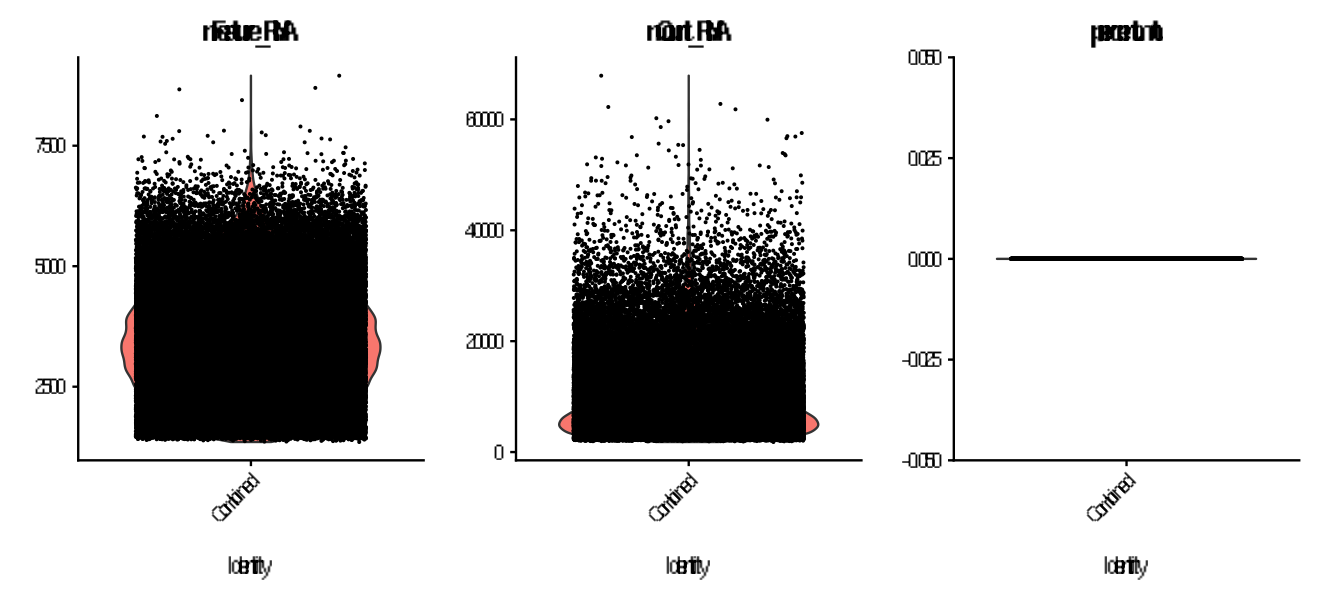

In [53]:
seaAD_obj <- CreateSeuratObject(counts = seaAD_counts,
                               meta.data = rbind(seaAD_pfc@meta.data[, cols], 
                                                 seaAD_mtg@meta.data[, cols]),
                               min.cells = 20)
dim(seaAD_obj)

seaAD_obj@meta.data$Donor_Region <- paste0(seaAD_obj@meta.data$donor_id, "_", seaAD_obj@meta.data$tissue)

### subset N per sample
Idents(seaAD_obj) <- seaAD_obj@meta.data$Donor_Region
seaAD_obj <- subset(seaAD_obj, downsample = 500) 
dim(seaAD_obj)

### regress out mito.percent and Sample effect
seaAD_obj <- PercentageFeatureSet(seaAD_obj, pattern = "^MT-", col.name = "percent.mt")
summary(seaAD_obj$percent.mt)

### QC
Idents(seaAD_obj) <- 'Combined'
VlnPlot(seaAD_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [54]:
seaAD_obj = SCTransform(seaAD_obj, vars.to.regress = c("Donor_Region"))
seaAD_obj = RunPCA(seaAD_obj, verbose = FALSE)
seaAD_obj = RunUMAP(seaAD_obj, reduction = "pca", dims = 1:30, verbose = FALSE)
seaAD_obj = FindNeighbors(seaAD_obj, reduction = "pca", dims = 1:30, verbose = FALSE) %>%
                FindClusters(resolution = 0.5, verbose = FALSE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21368 by 78812

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 41 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 21368 genes



  |======================================================================| 100%


Computing corrected count matrix for 21368 genes



  |======================================================================| 100%


Regressing out Donor_Region

Centering data matrix

Set default assay to SCT



In [56]:
#transfer
anchors = FindTransferAnchors(reference = ast_ref, query = seaAD_obj, dims = 1:30, 
                              reference.reduction = "pca", normalization.method = "SCT")
predictions = TransferData(anchorset = anchors, refdata = ast_ref$seurat_clusters, dims = 1:30) #Ast_clust
seaAD_obj = MapQuery(anchorset = anchors, reference = ast_ref, query = seaAD_obj, refdata = "seurat_clusters",  #Ast_clust
                 reference.reduction = "pca", reduction.model = "umap")

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 32007 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

23:12:02 Read 78812 rows

23:12:02 Processing block 1 of 1

23:12:02 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

23:12:03 Initializing by weighted average of neighbor coordinates using 1 thread

23:12:03 Commencing optimization for 67 epochs, with 2364360 positive edges

23:12:14 Finished



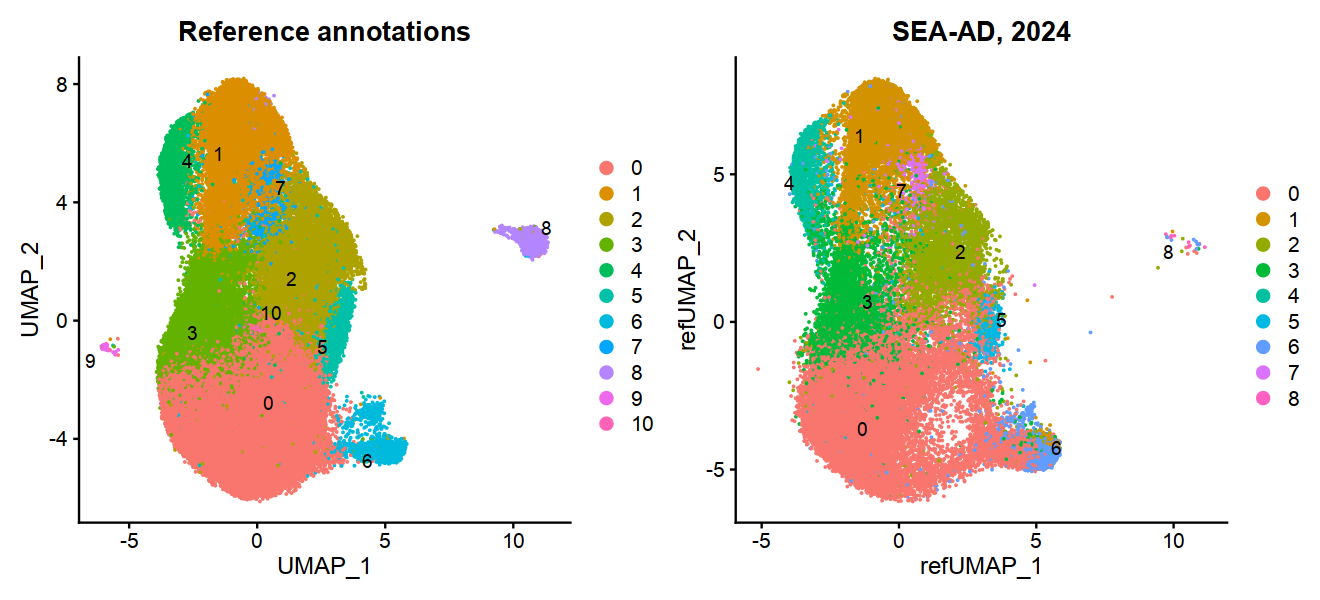

In [57]:
p1 = DimPlot(ast_ref, reduction = "umap", group.by = "seurat_clusters", repel = TRUE) + 
        ggtitle("Reference annotations") + 
        theme(text=element_text(size=14,  family="Arial")) 
p2 = DimPlot(seaAD_obj, reduction = "ref.umap", group.by = "predicted.id", repel = TRUE) + 
        ggtitle("SEA-AD, 2024") + #paste0("SEA-AD, 2024 (N = ", dim(seaAD_obj)[2], ")")
        theme(text=element_text(size=14,  family="Arial")) 

options(repr.plot.height = 5, repr.plot.width = 11)
LabelClusters(plot=p1, id = 'seurat_clusters', size = 4, family='Arial') + 
LabelClusters(p2, id = 'predicted.id', size = 4, family='Arial')

In [58]:
# saveRDS(seaAD_obj, "SEA-AD_projected.to-ast-resamped.to-1-2-3.20240228.rds")

#### Sadick et al

In [3]:
sadick_obj <- readRDS('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/Sadick/Sadick_astrocyte.rds')

In [4]:
sadick_obj

An object of class Seurat 
36601 features across 51214 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

[1] 27679 51214

[1] 27679  8075

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1634  0.3938  0.6906  0.8525 40.3008 

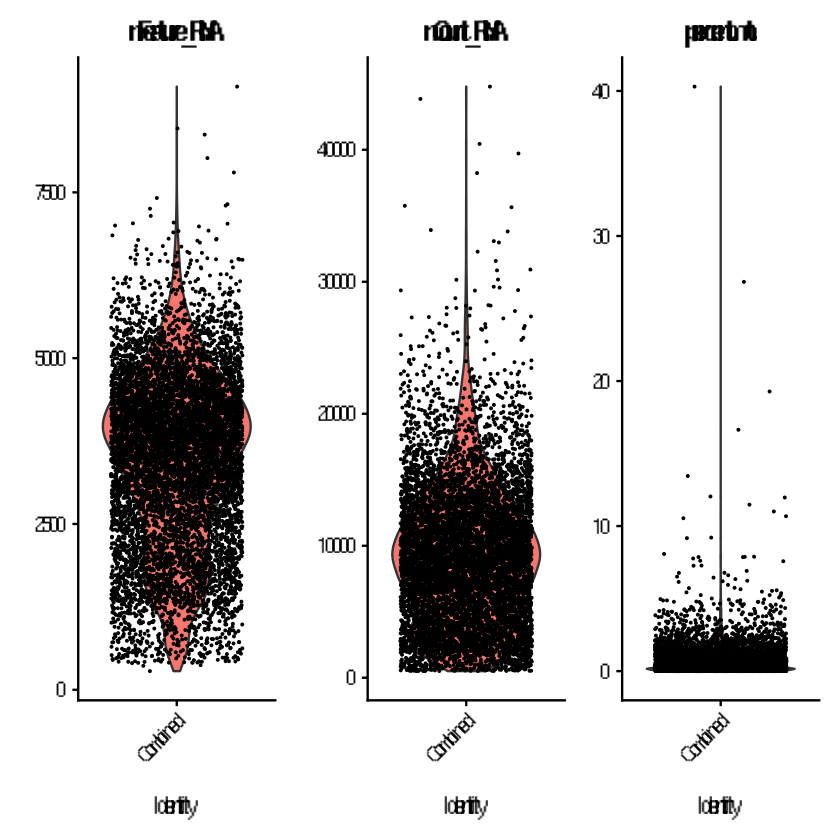

In [6]:
sadick <- CreateSeuratObject(counts = GetAssayData(sadick_obj, assay = 'RNA', slot = 'counts'),
                            meta.data = sadick_obj@meta.data,
                            min.cells = 20)
### all are astrocytes in this obj
dim(sadick)

### subset N per sample
Idents(sadick) <- sadick@meta.data$SampleName
sadick <- subset(sadick, downsample = 500) 
dim(sadick)

### regress out mito.percent and Sample effect
sadick <- PercentageFeatureSet(sadick, pattern = "^MT-", col.name = "percent.mt")
summary(sadick$percent.mt)
### QC
Idents(sadick) <- 'Combined'
VlnPlot(sadick, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [8]:
### nFeature_RNA: the number of genes detected in each cell
dim(sadick)
sadick <- subset(sadick, subset = nFeature_RNA > 200 & nFeature_RNA < 7500 & percent.mt <= 5)
dim(sadick)

[1] 27679  8023

[1] 27679  8023

In [9]:
sadick = SCTransform(sadick, vars.to.regress = c("percent.mt", "SampleName"))
sadick = RunPCA(sadick, verbose = FALSE)
sadick = RunUMAP(sadick, reduction = "pca", dims = 1:30, verbose = FALSE)
sadick = FindNeighbors(sadick, reduction = "pca", dims = 1:30, verbose = FALSE) %>%
          FindClusters(resolution = 0.5, verbose = FALSE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 26570 by 8023

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 40 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 26570 genes



  |======================================================================| 100%


Computing corrected count matrix for 26570 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.674569 mins

Determine variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, SampleName

Centering data matrix

Set default assay to SCT

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [13]:
#transfer
anchors = FindTransferAnchors(reference = ast_ref, query = sadick, dims = 1:30, 
                              reference.reduction = "pca", normalization.method = "SCT")
predictions = TransferData(anchorset = anchors, refdata = ast_ref$seurat_clusters, dims = 1:30) #Ast_clust

sadick = MapQuery(anchorset = anchors, reference = ast_ref, query = sadick, 
                 refdata = "seurat_clusters",  #"Ast_clust"
                 reference.reduction = "pca", reduction.model = "umap")

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 16932 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”
Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

10:43:21 Read 8023 rows

10:43:21 Processing block 1 of 1

10:43:21 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:43:22 Initializing by weighted average of neighbor coordinates using 1 thread

10:43:22 Commencing optimization for 67 epochs, with 240690 positive edges

10:43:23 Finished



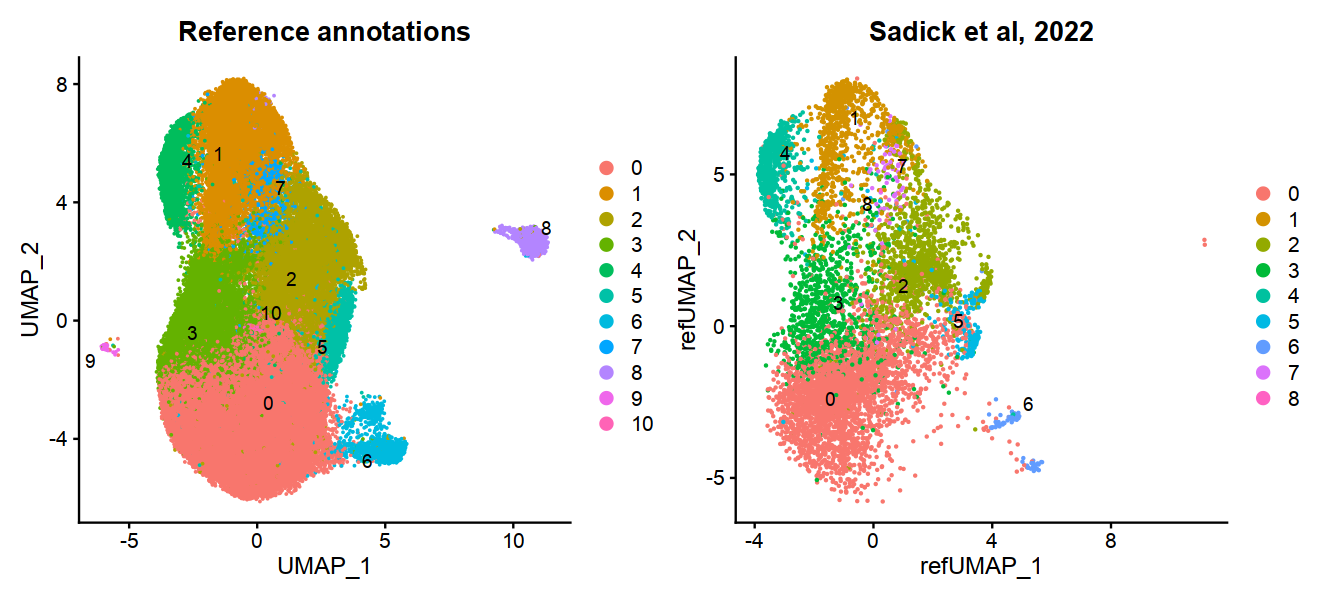

In [14]:
p1 = DimPlot(ast_ref, reduction = "umap", group.by = "seurat_clusters", repel = TRUE) + 
        ggtitle("Reference annotations") + 
        theme(text=element_text(size=14,  family="Arial")) 
p2 = DimPlot(sadick, reduction = "ref.umap", group.by = "predicted.id", repel = TRUE) + 
        ggtitle("Sadick et al, 2022") + #paste0("Lau et al, 2020 (N = ", dim(lau_obj)[2], ")")
        theme(text=element_text(size=14,  family="Arial")) 

options(repr.plot.height = 5, repr.plot.width = 11)
LabelClusters(plot=p1, id = 'seurat_clusters', size = 4, family='Arial') + 
LabelClusters(p2, id = 'predicted.id', size = 4, family='Arial')

In [15]:
# saveRDS(sadick, "sadick_projected.to-ast-resamped.to-1-2-3.20240228.rds")

#### Mathys

In [17]:
load('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/ROSMAP/Mathys-raw.Rdata')

[1] 16970  3392

[1] 16970  3392

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


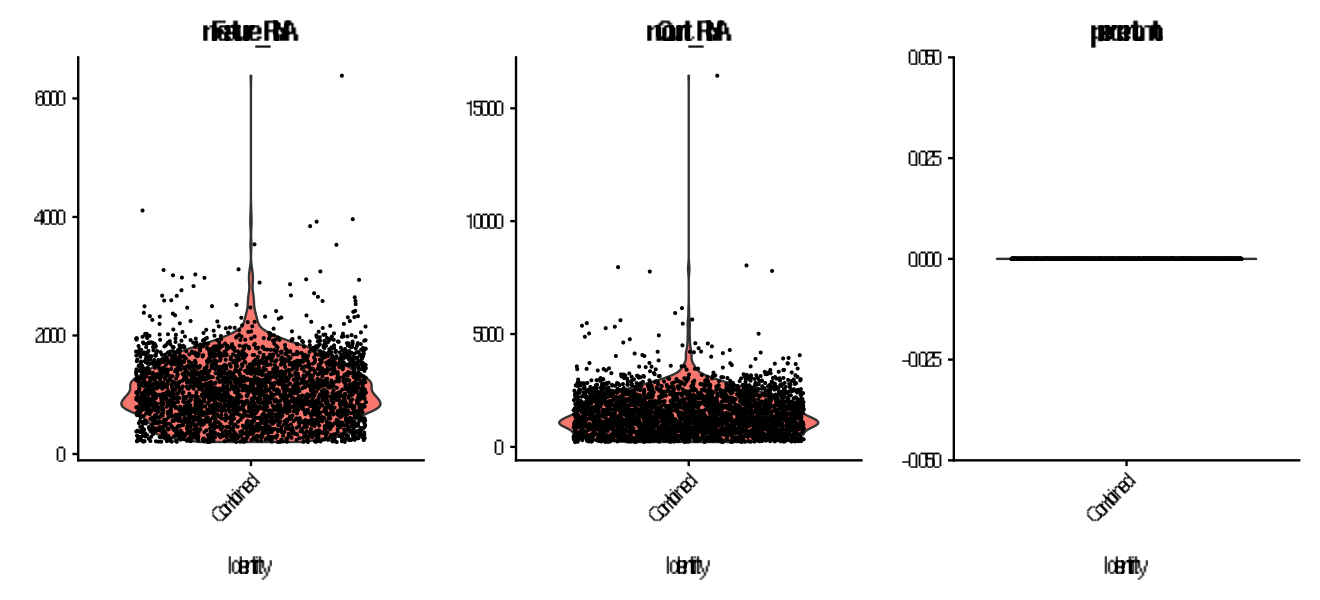

In [28]:
mathys_obj <- CreateSeuratObject(counts = GetAssayData(mathys, assay = 'RNA', slot = 'counts'),
                            meta.data = mathys@meta.data,
                            min.cells = 20)
### all are astrocytes in this obj
mathys_obj <- mathys_obj[,mathys_obj$broad.cell.type=='Ast']
dim(mathys_obj)

### subset N per sample
Idents(mathys_obj) <- mathys_obj@meta.data$MathysId
mathys_obj <- subset(mathys_obj, downsample = 500) 
dim(mathys_obj)

### regress out mito.percent and Sample effect
mathys_obj <- PercentageFeatureSet(mathys_obj, pattern = "^MT-", col.name = "percent.mt")
summary(mathys_obj$percent.mt)
### QC
Idents(mathys_obj) <- 'Combined'
VlnPlot(mathys_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [29]:
mathys_obj = SCTransform(mathys_obj, vars.to.regress = c("MathysId"))
mathys_obj = RunPCA(mathys_obj, verbose = FALSE)
mathys_obj = RunUMAP(mathys_obj, reduction = "pca", dims = 1:30, verbose = FALSE)
mathys_obj = FindNeighbors(mathys_obj, reduction = "pca", dims = 1:30, verbose = FALSE) %>%
          FindClusters(resolution = 0.5, verbose = FALSE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 14775 by 3392

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3392 cells



  |======================================================================| 100%


Found 51 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 14775 genes



  |======================================================================| 100%


Computing corrected count matrix for 14775 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 47.94121 secs

Determine variable features

Place corrected count matrix in counts slot

Regressing out MathysId

Centering data matrix

Set default assay to SCT



In [33]:
#transfer
anchors = FindTransferAnchors(reference = ast_ref, query = mathys_obj, dims = 1:30, 
                              reference.reduction = "pca", normalization.method = "SCT")
predictions = TransferData(anchorset = anchors, refdata = ast_ref$seurat_clusters, dims = 1:30) #Ast_clust

mathys_obj = MapQuery(anchorset = anchors, reference = ast_ref, query = mathys_obj, 
                 refdata = "seurat_clusters",  #"Ast_clust"
                 reference.reduction = "pca", reduction.model = "umap")

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 6003 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

11:17:58 Read 3392 rows

11:17:58 Processing block 1 of 1

11:17:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:17:58 Initializing by weighted average of neighbor coordinates using 1 thread

11:17:58 Commencing optimization for 67 epochs, with 101760 positive edges

11:17:59 Finished



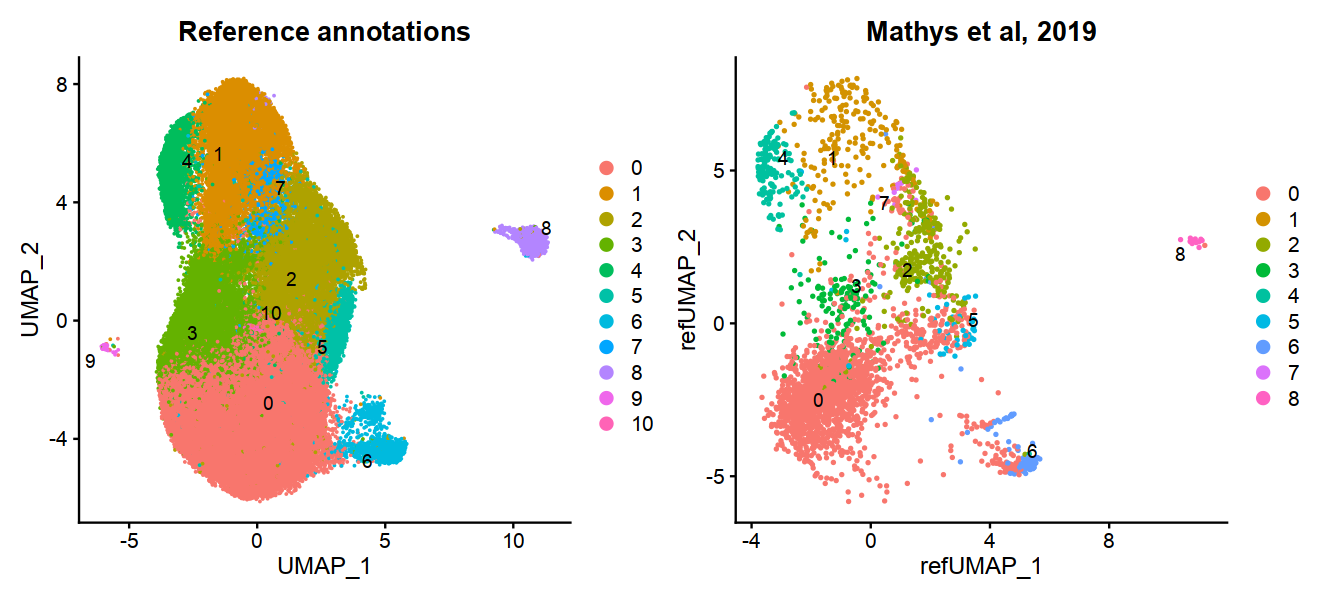

In [34]:
p1 = DimPlot(ast_ref, reduction = "umap", group.by = "seurat_clusters", repel = TRUE) + 
        ggtitle("Reference annotations") + 
        theme(text=element_text(size=14,  family="Arial")) 
p2 = DimPlot(mathys_obj, reduction = "ref.umap", group.by = "predicted.id", repel = TRUE) + 
        ggtitle("Mathys et al, 2019") + #paste0("Lau et al, 2020 (N = ", dim(lau_obj)[2], ")")
        theme(text=element_text(size=14,  family="Arial")) 

options(repr.plot.height = 5, repr.plot.width = 11)
LabelClusters(plot=p1, id = 'seurat_clusters', size = 4, family='Arial') + 
LabelClusters(p2, id = 'predicted.id', size = 4, family='Arial')

In [35]:
# saveRDS(mathys_obj, "mathys_projected.to-ast-resamped.to-1-2-3.20240228.rds")

#### Grubman et al

In [40]:
load('/space/mindds/1/projects/AbbvieSnRNASeq/data/published_AD/Grubman/Grubman-raw.Rdata')

[1] 10844  2129

[1] 10844  2048

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05198 0.13271 0.34033 0.36842 8.42697 

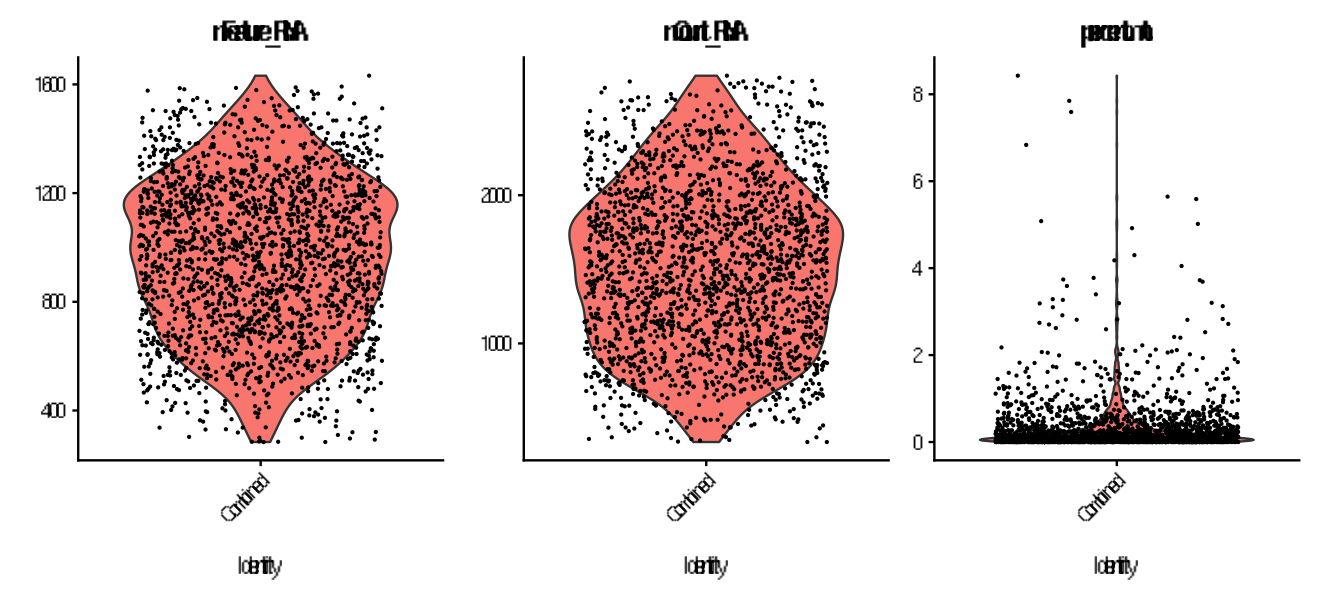

In [48]:
grubman_obj <- CreateSeuratObject(counts = GetAssayData(grubman, assay = 'RNA', slot = 'counts'),
                            meta.data = grubman@meta.data,
                            min.cells = 20)
### all are astrocytes in this obj
grubman_obj <- grubman_obj[,grubman_obj$cellType=='astro']
grubman_obj <- grubman_obj[,grubman_obj$patient %in% c('AD1','AD2','AD3','AD4','AD5','AD6',
                                                       'Ct1','Ct2','Ct3','Ct4','Ct5','Ct6')]  
dim(grubman_obj)

### subset N per sample
Idents(grubman_obj) <- grubman_obj@meta.data$patient
grubman_obj <- subset(grubman_obj, downsample = 500) 
dim(grubman_obj)

### regress out mito.percent and Sample effect
grubman_obj <- PercentageFeatureSet(grubman_obj, pattern = "^MT-", col.name = "percent.mt")
summary(grubman_obj$percent.mt)
### QC
Idents(grubman_obj) <- 'Combined'
VlnPlot(grubman_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [49]:
grubman_obj = SCTransform(grubman_obj, vars.to.regress = c("patient"))
grubman_obj = RunPCA(grubman_obj, verbose = FALSE)
grubman_obj = RunUMAP(grubman_obj, reduction = "pca", dims = 1:30, verbose = FALSE)
grubman_obj = FindNeighbors(grubman_obj, reduction = "pca", dims = 1:30, verbose = FALSE) %>%
              FindClusters(resolution = 0.5, verbose = FALSE)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 10765 by 2048

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 2048 cells



  |======================================================================| 100%


Found 67 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 10765 genes



  |======================================================================| 100%


Computing corrected count matrix for 10765 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 23.33972 secs

Determine variable features

Place corrected count matrix in counts slot

Regressing out patient

Centering data matrix

Set default assay to SCT



In [51]:
#transfer
anchors = FindTransferAnchors(reference = ast_ref, query = grubman_obj, dims = 1:30, 
                              reference.reduction = "pca", normalization.method = "SCT")
predictions = TransferData(anchorset = anchors, refdata = ast_ref$seurat_clusters, dims = 1:30) #Ast_clust

grubman_obj = MapQuery(anchorset = anchors, reference = ast_ref, query = grubman_obj, 
                 refdata = "seurat_clusters",  #"Ast_clust"
                 reference.reduction = "pca", reduction.model = "umap")

Normalizing query using reference SCT model

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 2917 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Finding integration vectors

Finding integration vector weights

Predicting cell labels


Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Computing nearest neighbors

Running UMAP projection

11:42:52 Read 2048 rows

11:42:52 Processing block 1 of 1

11:42:52 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:42:52 Initializing by weighted average of neighbor coordinates using 1 thread

11:42:52 Commencing optimization for 67 epochs, with 61440 positive edges

11:42:52 Finished



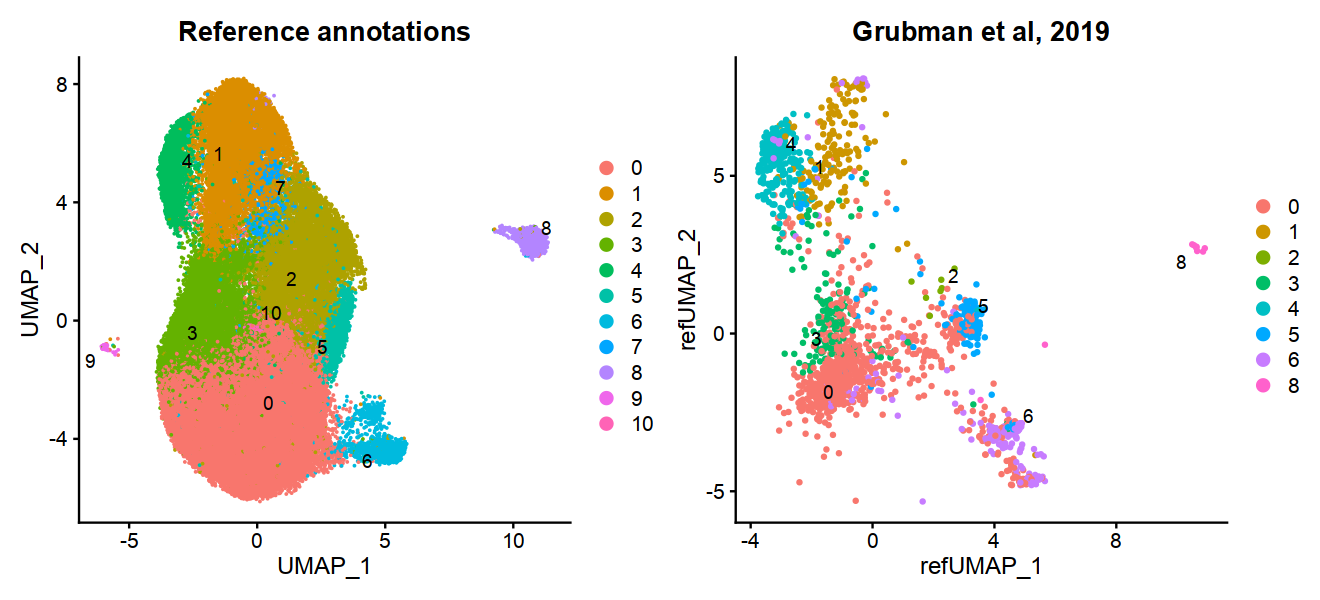

In [52]:
p1 = DimPlot(ast_ref, reduction = "umap", group.by = "seurat_clusters", repel = TRUE) + 
        ggtitle("Reference annotations") + 
        theme(text=element_text(size=14,  family="Arial")) 
p2 = DimPlot(grubman_obj, reduction = "ref.umap", group.by = "predicted.id", repel = TRUE) + 
        ggtitle("Grubman et al, 2019") + #paste0("Lau et al, 2020 (N = ", dim(lau_obj)[2], ")")
        theme(text=element_text(size=14,  family="Arial")) 

options(repr.plot.height = 5, repr.plot.width = 11)
LabelClusters(plot=p1, id = 'seurat_clusters', size = 4, family='Arial') + 
LabelClusters(p2, id = 'predicted.id', size = 4, family='Arial')

In [53]:
# saveRDS(grubman_obj, "grubman_projected.to-ast-resamped.to-1-2-3.20240228.rds")

#### plot to one

In [3]:
my_theme <- theme(strip.background = element_blank(),
            strip.text = element_text(size = 12),  # Adjust the facet title font size here
            text=element_text(size=12,  family="Arial"), #sans
            axis.text.x = element_text(size=12),
            axis.text.y = element_text(size=12),
            axis.title.x = element_text(size=12),
            axis.title.y = element_text(size=12),
            legend.position = "right")

In [4]:
ast_obj <- readRDS('../4th_samp_by_hl_500-per-Sample/seurat_harmony_70674x25802.rds') #ast_resamped_projected.20240228.rds
mathys_obj <- readRDS('mathys_projected.to-ast-resamped.to-1-2-3.20240228.rds')
grubman_obj <- readRDS('grubman_projected.to-ast-resamped.to-1-2-3.20240228.rds')
lau_obj <- readRDS('./lau_projected.to-ast-resamped.to-1-2-3.20240228.rds')
leng_obj <- readRDS('./leng_projected.to_ast-resamped.to-1-2-3.20240228.rds')
sadick_obj <- readRDS('./sadick_projected.to-ast-resamped.to-1-2-3.20240228.rds')
smith_obj <- readRDS('./smith_projected.to_ast-resamped.to-1-2-3.20240228.rds')
dai_obj <- readRDS('./dai_projected_2ast-resamped.to-1-2-3.20240228.rds')
seaAD_obj <- readRDS('./SEA-AD_projected.to-ast-resamped.to-1-2-3.20240228.rds')

In [6]:
process_umap <- function(obj, title, label_rename) {
    # move astIM3, the outlier sub-cluster
    obj[["umap"]]@cell.embeddings[,1][obj[["umap"]]@cell.embeddings[,1] > 6] <- obj[["umap"]]@cell.embeddings[,1][obj[["umap"]]@cell.embeddings[,1] > 6] - 5
    # Exchange x and y
    obj[["umap"]]@cell.embeddings <- obj[["umap"]]@cell.embeddings[, c(2,1)]
    colnames(obj[["umap"]]@cell.embeddings) <- c('UMAP_1','UMAP_2')
    # Flip
    obj[["umap"]]@cell.embeddings[, 2] <- -1*obj[["umap"]]@cell.embeddings[, 2]
    # rename label
    obj$seurat_clusters_org = paste0('c.', obj$seurat_clusters)
    obj$seurat_clusters_renamed <- factor(label_rename[obj$seurat_clusters_org], 
                                          levels = sort(unique(label_rename[obj$seurat_clusters_org])))
    Idents(obj) <- obj$seurat_clusters_renamed
    # Create plot
    p1 <- DimPlot(object = obj, reduction = "umap", pt.size = .05, group.by = "seurat_clusters_renamed") + 
            ggtitle(title) +
            theme(text=element_text(size=14, family="Arial")) +
            NoLegend() +
            ylim(-7.5,6)
    #p1 <- LabelClusters(plot=p1, id = 'seurat_clusters_renamed', size = 4, family='Arial') # + scale_color_npg()
    # Return the plot
    return(p1)
}

In [7]:
process_ref_umap <- function(obj, title, label_rename) {
    obj[["ref.umap"]]@cell.embeddings[,1][obj[["ref.umap"]]@cell.embeddings[,1] > 6] <- obj[["ref.umap"]]@cell.embeddings[,1][obj[["ref.umap"]]@cell.embeddings[,1] > 6] - 5
    # Exchange x and y
    obj[["ref.umap"]]@cell.embeddings <- obj[["ref.umap"]]@cell.embeddings[, c(2,1)]
    colnames(obj[["ref.umap"]]@cell.embeddings) <- c('refUMAP_1','refUMAP_2')
    # Flip
    obj[["ref.umap"]]@cell.embeddings[, 2] <- -1*obj[["ref.umap"]]@cell.embeddings[, 2]
    # rename label
    obj$seurat_clusters_org = paste0('c.', obj$predicted.id)
    obj$seurat_clusters_renamed <- factor(label_rename[obj$seurat_clusters_org], 
                                          levels = sort(unique(label_rename[obj$seurat_clusters_org])))
    Idents(obj) <- obj$seurat_clusters_renamed
    # Create plot
    p1 <- DimPlot(object = obj, reduction = "ref.umap", pt.size = .05, group.by = "seurat_clusters_renamed") + 
            ggtitle(title) +
            theme(text=element_text(size=14, family="Arial")) +
            NoLegend() +
            ylim(-7.5,6)
    #p1 <- LabelClusters(plot=p1, id = 'seurat_clusters_renamed', size = 4, family='Arial') #+ scale_color_npg()
    # Return the plot
    return(p1) 
}

In [9]:
label_rename = c('c.0' = '0_astH',
                 'c.6' = '1_astIM',
                 'c.3' = '2_astIM',
                 'c.5' = '3_astIM',
                 'c.2' = '4_astIM',
                 'c.8' = '5_astIM',
                 'c.7' = '6_astIM',
                 'c.1' = '7_astR1',
                 'c.4' = '8_astR2')

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


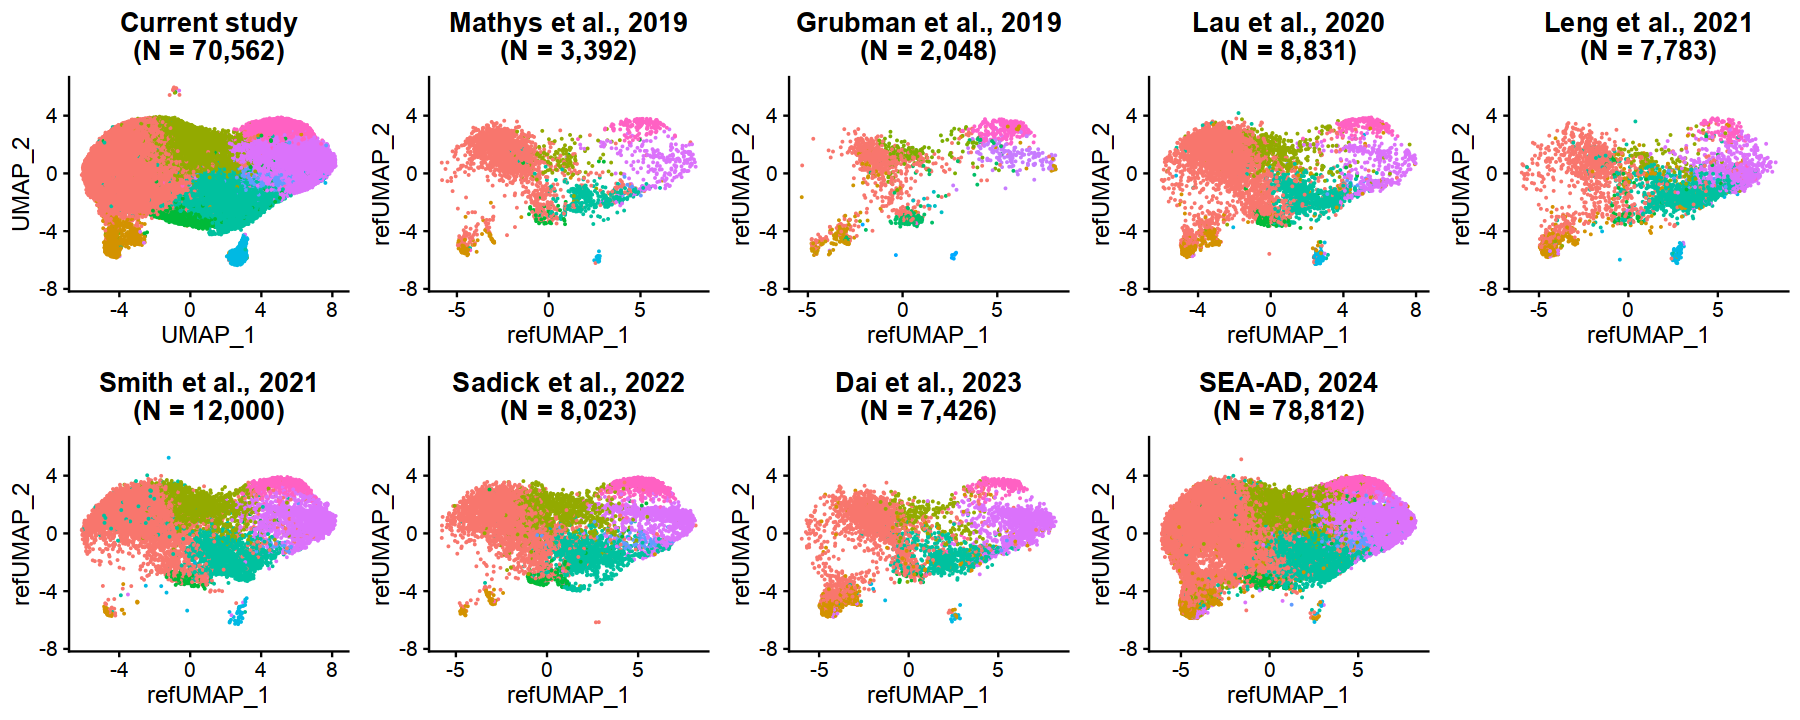

In [10]:
obj_list = c(ast_obj, mathys_obj, grubman_obj, lau_obj, 
             leng_obj, smith_obj, sadick_obj, dai_obj, seaAD_obj)
name_list = c("Current study", "Mathys et al., 2019", "Grubman et al., 2019", "Lau et al., 2020",
             "Leng et al., 2021", "Smith et al., 2021", "Sadick et al., 2022", "Dai et al., 2023", 
              "SEA-AD, 2024")

ast_plot <- process_umap(obj_list[[1]], 
                        paste0(name_list[1], "\n(N = ", format(dim(obj_list[[1]])[2], big.mark = ","), ")"),
                        label_rename)
other_plots <- lapply(2:9, function(i) process_ref_umap(obj_list[[i]], 
                        paste0(name_list[i],  "\n(N = ", format(dim(obj_list[[i]])[2], big.mark = ","), ")"),
                        label_rename))

options(repr.plot.height = 6, repr.plot.width = 15)
gridExtra::grid.arrange(grobs = c(list(ast_plot), other_plots), ncol = 5)

## Fig7b - subcluster proportion in each dataset

In [11]:
### df_stats must have SampleID, PathStage, predicted.id, samp_clust_pecent column
extract_clust <- function(df_stats, clust_id, dataset_name) {
    df_stats_all_samp <- df_stats %>% ungroup() %>%
                            select(SampleID, PathStage) %>%
                            distinct()
    df_stats <- df_stats %>% ungroup() %>%
             filter(predicted.id == clust_id) %>%
             select(SampleID, predicted.id, samp_clust_pecent, PathStage) %>%
             unique()
    
    df_stats <- merge(df_stats_all_samp, df_stats, by=c('SampleID','PathStage'), all.x=T)
    df_stats$dataset=dataset_name
    df_stats$predicted.id = clust_id
    df_stats$samp_clust_pecent[is.na(df_stats$samp_clust_pecent)] <- 0 ### fill na with 0
    
    # Perform pairwise t-test
    if (length(unique(df_stats$PathStage)) == 2) {
        stats_test <- t_test(df_stats, samp_clust_pecent ~ PathStage, 
                                paired=FALSE, var.equal = FALSE) ### Welch’s t test
        stats_test$group_n = 2
        stats_test$p.adj <- stats_test$p
        stats_test$p.adj.signif <- 'toadded'
    } else {
        stats_test <- pairwise_t_test(df_stats, samp_clust_pecent ~ PathStage, 
                                      paired = FALSE,
                                      pool.sd = FALSE, var.equal=FALSE,
                                      p.adjust.method = "bonferroni") ### Welch’s t test for each 2 groups
        stats_test$group_n = length(unique(df_stats$PathStage))
    }
    stats_test$dataset <- dataset_name
    return(list(df_stats = df_stats, stats_test = stats_test))
}

Current Study

In [12]:
ast_stats <- ast_obj@meta.data %>%
                group_by(SampleName) %>% 
                mutate(samp_n = n()) %>% 
                group_by(SampleName, seurat_clusters) %>%  #seurat_clusters, Ast_clust
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)

ast_stats$predicted.id <- ast_stats$seurat_clusters
ast_stats$SampleID <- ast_stats$SampleName
name_to_pathstage <- c(
  "1" = "Braak 0-II",
  "2" = 'Braak III-IV',
  "3" = "Braak V",
  "4" = "Braak VI")
ast_stats$PathStage <- factor(name_to_pathstage[ast_stats$Path..Group.], 
                              levels=c('Braak 0-II', 'Braak III-IV', 'Braak V', 'Braak VI'))

Lau et al

In [13]:
lau_stats <- lau_obj@meta.data %>%
                group_by(Donor.ID) %>% 
                mutate(samp_n = n()) %>% 
                group_by(Donor.ID, predicted.id) %>% 
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)

lau_stats$SampleID <- lau_stats$Donor.ID
name_to_pathstage <- c(
  "NC" = "Control",
  "AD" = 'AD')
lau_stats$PathStage <- factor(name_to_pathstage[gsub("[^A-Za-z]", "", lau_stats$Donor.ID)], 
                              levels=c('Control', 'AD'))

Leng et al¶

In [14]:
leng_stats <- leng_obj@meta.data %>%
                group_by(SampleID) %>% 
                mutate(samp_n = n()) %>% 
                group_by(SampleID, predicted.id) %>% 
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)

name_to_pathstage <- c(
  "0" = "Braak 0-II",
  "2" = 'Braak 0-II',
  "6" = 'Braak VI')
leng_stats$PathStage <- factor(name_to_pathstage[leng_stats$BraakStage])

SEA-AD

In [15]:
seaAD_stats <- seaAD_obj@meta.data %>%
                group_by(Donor_Region) %>% 
                mutate(samp_n = n()) %>% 
                group_by(Donor_Region, predicted.id) %>% 
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)
seaAD_stats$SampleID <- seaAD_stats$Donor_Region

braak_to_pathstage <- c(
  "Reference" = "Reference",
  "Braak 0" = 'Braak 0-II', #'PathStage 1',
  "Braak II" = 'Braak 0-II',
  "Braak III" = 'Braak III-IV', #'PathStage 2',
  "Braak IV" = 'Braak III-IV',
  "Braak V" = 'Braak V', #'PathStage 3',
  "Braak VI" = 'Braak VI'
)

seaAD_stats$PathStage <- braak_to_pathstage[seaAD_stats$Braak.stage]
seaAD_stats = seaAD_stats[seaAD_stats$PathStage %in% c('Braak 0-II','Braak III-IV','Braak V','Braak VI'),]
seaAD_stats$PathStage <- factor(seaAD_stats$PathStage, 
                                levels=c('Braak 0-II','Braak III-IV','Braak V','Braak VI'))

Mathys

In [16]:
mathys_stats <- mathys_obj@meta.data %>%
                group_by(MathysId) %>% 
                mutate(samp_n = n()) %>% 
                group_by(MathysId, predicted.id) %>% 
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)

mathys_stats$SampleID <- mathys_stats$MathysId
mathys_stats$PathStage <- mathys_stats$pathology.group

Grubman¶

In [17]:
grubman_stats <- grubman_obj@meta.data %>%
                group_by(patient) %>% 
                mutate(samp_n = n()) %>% 
                group_by(patient, predicted.id) %>% 
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)

grubman_stats$SampleID <- grubman_stats$patient
name_to_pathstage <- c(
  "ct" = "Control",
  "AD" = 'AD')
grubman_stats$PathStage <- factor(name_to_pathstage[grubman_stats$batchCond], levels=c("Control",'AD'))

Smith

In [18]:
smith_stats <- smith_obj@meta.data %>%
                group_by(name_seurat) %>% 
                mutate(samp_n = n()) %>% 
                group_by(name_seurat, predicted.id) %>% 
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)
smith_stats$SampleID <- smith_stats$name_seurat
braak_to_pathstage <- c(
  "Non disease control" = "Control",
  "Non-disease control" = 'Control', #'PathStage 1',
  "AD" = 'AD')

smith_stats$PathStage <- braak_to_pathstage[smith_stats$disease_state]
smith_stats$PathStage <- factor(smith_stats$PathStage, levels=c('Control','AD'))

Sadick

In [19]:
sadick_stats <- sadick_obj@meta.data %>%
                group_by(SampleName) %>% 
                mutate(samp_n = n()) %>% 
                group_by(SampleName, predicted.id) %>% 
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)

sadick_stats$SampleID <- sadick_stats$SampleName
name_to_pathstage <- c(
  "NS" = "Control",
  "AD" = 'AD')
sadick_stats$PathStage <- factor(name_to_pathstage[sadick_stats$DISDX], levels=c('Control','AD'))

Dai

In [21]:
dai_obj@meta.data$PathStage=NULL
dai_obj@meta.data$PathStage[dai_obj@meta.data$sampleID %in% c(1,2,3,4)] = 'Control'
dai_obj@meta.data$PathStage[!dai_obj@meta.data$sampleID %in% c(1,2,3,4)] = 'AD'

dai_stats <- dai_obj@meta.data %>%
                group_by(sampleID) %>% 
                mutate(samp_n = n()) %>% 
                group_by(sampleID, predicted.id) %>% 
                mutate(samp_clust_n = n()) %>% 
                mutate(samp_clust_pecent = samp_clust_n/samp_n)

dai_stats$SampleID <- dai_stats$sampleID
dai_stats$PathStage <- factor(dai_stats$PathStage, levels=c('Control','AD'))

plot, cluster id = 2 = astTinf

In [35]:
library(rstatix)
library(ggsignif)
cb_palette <- "Paired"

In [22]:
add_signif <- function(p_list) {
    p.signif <- rep(NA, length(p_list))
    p.signif[p_list < 0.001] <- '***'
    p.signif[p_list >= 0.001 & p_list < 0.01] <- '**'
    p.signif[p_list >= 0.01 & p_list < 0.05] <- '*'
    p.signif[p_list >= 0.05] <- 'ns'
    return(p.signif)
}

In [23]:
clust_id = 2
clust_id_name = 'astTinf'

In [27]:
df_list = list(ast_stats, mathys_stats, grubman_stats, lau_stats, 
             leng_stats, smith_stats, sadick_stats, dai_stats, seaAD_stats) #ast_stats, 
name_list = c("Current Study", "Mathys et al., 2019", "Grubman et al., 2019", "Lau et al., 2020",
             "Leng et al., 2021", "Smith et al., 2021", "Sadick et al., 2022", "Dai et al., 2023", 
              "SEA-AD, 2024")

df_combined <- do.call(rbind, 
                       lapply(1:9, function(i) extract_clust(df_list[[i]], clust_id, name_list[i])$df_stats))
df_combined$dataset <- factor(df_combined$dataset, levels=name_list)

df_combined$samp_clust_pecent <- 100*df_combined$samp_clust_pecent
max(df_combined$samp_clust_pecent)

[1] 91.17647

In [28]:
df_combined$PathStage <- factor(df_combined$PathStage, levels=c('PathStage 1','PathStage 2','PathStage 3','PathStage 4',
                                       'no-pathology','early-pathology','late-pathology',
                                       'Control','AD',
                                       'Braak 0','Braak II',
                                       'Braak 0-II','Braak III-IV','Braak V','Braak VI'))

In [31]:
y_axis_label = paste0('Frequency of Cluster ', clust_id_name, " (%)")
options(repr.plot.height = 6, repr.plot.width = 11)
p <- ggplot(df_combined, aes(x=PathStage, y=samp_clust_pecent, fill=PathStage)) +
  geom_point(color='gray50', size = .5, alpha = 0.8,
                       position = position_jitter(width = .15)) + #mapping=aes(color=Unified_region),  
  geom_boxplot(width = .2, outlier.shape = NA, alpha = 0.5) +
  facet_wrap(dataset ~ ., scales = "free_x", ncol = 9) + 
  theme_minimal() + 
  my_theme  +
  ylim(0, 80) +
  labs(x = "", y = y_axis_label) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), 
        panel.border = element_rect(color = "gray50", fill = NA, size = 1))+
  scale_fill_brewer(palette=cb_palette) +
  scale_color_brewer(palette=cb_palette) +
  theme(legend.position="none")
# p

In [32]:
stats_combined <- do.call(rbind, 
                       lapply(1:9, function(i) extract_clust(df_list[[i]], clust_id, name_list[i])$stats_test))
stats_combined$dataset <- factor(stats_combined$dataset, levels=name_list)

In [33]:
### add p value to Current Study
stats_combined_1 <- stats_combined[stats_combined$dataset == 'Current Study',]
# Only care about Stage3-vs-Others
stats_combined_1 <- stats_combined_1[(stats_combined_1$group1=='Braak VI') | 
                                     (stats_combined_1$group2=='Braak VI'),] 
stats_combined_1$p.adj <- p.adjust(stats_combined_1$p, "BH")
stats_combined_1$p.adj.signif <- add_signif(stats_combined_1$p.adj)

In [36]:
### Cluster 2
p1 <- p + geom_signif(
        inherit.aes = F,
        data = stats_combined_1,
        aes(xmin = group1, xmax = group2, annotations = p.adj.signif, y_position = c(78,70,62)),
        textsize = 4, vjust = 0.6, family='Arial',
        manual = TRUE)

Warning message in geom_signif(inherit.aes = F, data = stats_combined_1, aes(xmin = group1, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


In [38]:
stats_combined_2 <- stats_combined[stats_combined$group_n==2,]
p2 <- p1 + geom_signif(
        inherit.aes = F,
        data = stats_combined_2,
        aes(xmin = group1, xmax = group2, annotations = 'ns', y_position = 70),
        textsize = 4, vjust = -0.4, family='Arial',
        manual = TRUE)

Warning message in geom_signif(inherit.aes = F, data = stats_combined_2, aes(xmin = group1, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


In [39]:
### add p value to Mathys
stats_combined_3 <- stats_combined[stats_combined$dataset == 'Mathys et al., 2019',]
stats_combined_3 <- stats_combined_3[(stats_combined_3$group1=='no-pathology') | 
                                     (stats_combined_3$group2=='no-pathology'),] 
stats_combined_3$p.adj <- p.adjust(stats_combined_3$p, "BH")
stats_combined_3$p.adj.signif <- add_signif(stats_combined_3$p.adj)

In [40]:
p3 <- p2 + geom_signif(
        inherit.aes = F,
        data = stats_combined_3,
        aes(xmin = group1, xmax = group2, annotations = p.adj.signif, y_position = c(60, 70)),
        textsize = 4, vjust = -0.1, family='Arial', 
        manual = TRUE) #size = 0: hide line

Warning message in geom_signif(inherit.aes = F, data = stats_combined_3, aes(xmin = group1, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


In [41]:
### add p value to SEA-AD
stats_combined_4 <- stats_combined[stats_combined$dataset == 'SEA-AD, 2024',]
stats_combined_4 <- stats_combined_4[(stats_combined_4$group1=='Braak 0-II') | 
                                     (stats_combined_4$group2=='Braak 0-II'),] 
stats_combined_4$p.adj <- p.adjust(stats_combined_4$p, "BH")
stats_combined_4$p.adj.signif <- add_signif(stats_combined_4$p.adj)

In [42]:
p4 <- p3 + geom_signif(
        inherit.aes = F,
        data = stats_combined_4,
        aes(xmin = group1, xmax = group2, annotations = p.adj.signif, y_position = c(55,65,75)),
        textsize = 4, vjust = -0.1, family='Arial', 
        manual = TRUE) #size = 0: hide line

Warning message in geom_signif(inherit.aes = F, data = stats_combined_4, aes(xmin = group1, :
“Ignoring unknown aesthetics: xmin, xmax, annotations, and y_position”


Warning message:
“Removed 3 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 22 rows containing missing values (`geom_point()`).”


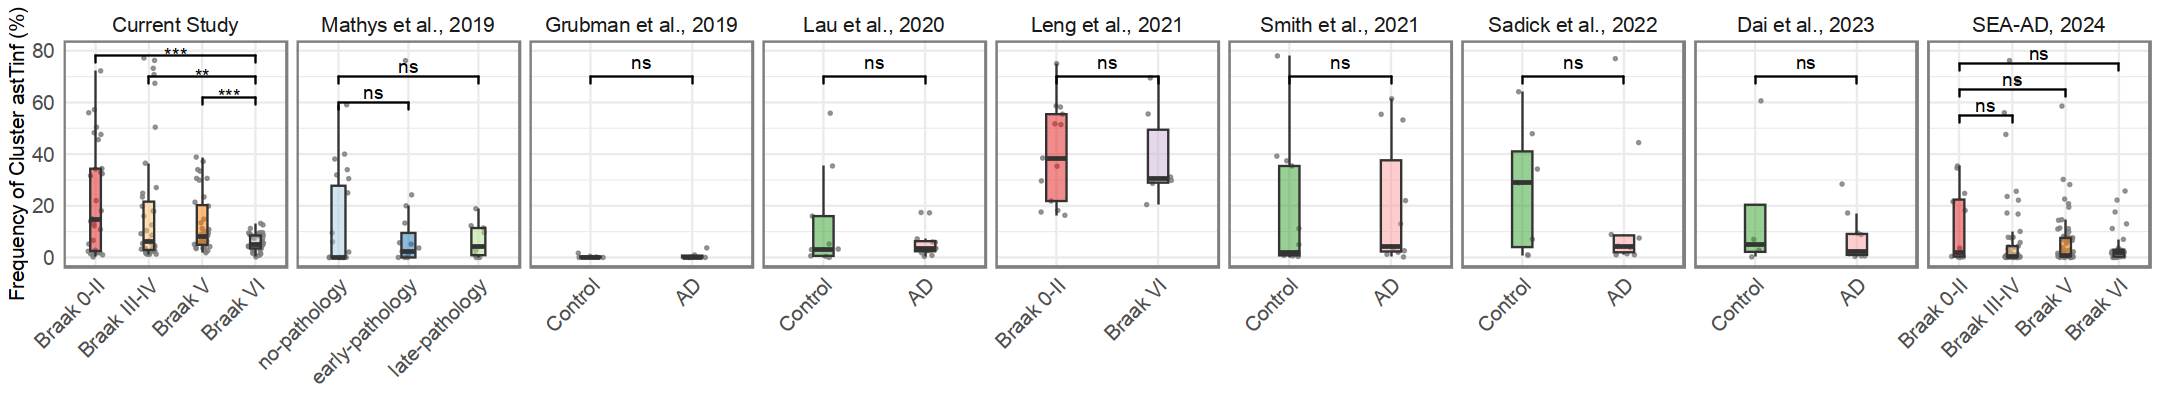

In [43]:
options(repr.plot.height = 3.5, repr.plot.width = 18)
p4

## Fig7c - Gene set Overlap

In [44]:
library("GeneOverlap")
library(dplyr)
packageVersion("GeneOverlap")

[1] ‘1.30.0’

Public Dataset

In [45]:
Mathys_Ast0 <- read.csv('./Markers_of_each_study/mathys-Ast0.csv') %>% pull(GeneName)
Mathys_Ast1 <- read.csv('./Markers_of_each_study/mathys-Ast1.csv') %>% pull(GeneName)
Grubman_a1 <- read.csv('./Markers_of_each_study/Grubman_2019_a1.csv') %>% filter(LFC>0.25 & FDR<0.05)%>% pull(geneName)
Grubman_a2 <- read.csv('./Markers_of_each_study/Grubman_2019_a2.csv') %>% filter(LFC>0.25 & FDR<0.05)%>% pull(geneName)
Lau_ast_up <- read.csv('./Markers_of_each_study/Lau_ast_up.csv') %>% pull(GeneName)
Lau_ast_dn <- read.csv('./Markers_of_each_study/Lau_ast_dn.csv') %>% pull(GeneName)
Leng_EC.astro.s3.up <- read.csv('./Markers_of_each_study/Leng_EC.astro.s3.up.csv') %>% pull(GeneName)
Leng_SFG.astro.s4.up <- read.csv('./Markers_of_each_study/Leng_SFG.astro.s4.up.csv') %>% pull(GeneName)
Leng_SFG.astro.s5.up <- read.csv('./Markers_of_each_study/Leng_SFG.astro.s5.up.csv') %>% pull(GeneName)
Smith_pTau_pos <- read.csv('./Markers_of_each_study/Smith_pTau_pos.csv') %>% pull(gene)
Smith_pTau_neg <- read.csv('./Markers_of_each_study/Smith_pTau_neg.csv') %>% pull(gene)
Saddick_Ast_AD_up <- read.csv('./Markers_of_each_study/Saddick_Ast_AD_up.csv')  %>% pull(GeneName)
Saddick_Ast_AD_dn <- read.csv('./Markers_of_each_study/Saddick_Ast_AD_dn.csv')  %>% pull(GeneName)
Dai_reactivity <- read.csv('./Markers_of_each_study/Dai_reactivity-associated.csv')
Dai_reactivity_up <- read.csv('./Markers_of_each_study/Dai_reactivity-associated.csv') %>% 
                            filter(Top.Dysregulated == 'Upregulated') %>% pull(Gene)
Dai_reactivity_dn <- read.csv('./Markers_of_each_study/Dai_reactivity-associated.csv') %>% 
                            filter(Top.Dysregulated == 'Downregulated') %>% pull(Gene)
SEA_AD_astro2 <- read.csv('./Markers_of_each_study/SEA-AD_Astro2.csv') %>% pull(GeneName)

In [46]:
dataset_genelist = list('Mathys_Ast0'=Mathys_Ast0, 'Mathys_Ast1'=Mathys_Ast1,
        'Grubman_a1'=Grubman_a1, 'Grubman_a2'=Grubman_a2,
        'Lau_ast_up'=Lau_ast_up, 'Lau_ast_dn'=Lau_ast_dn,
        'Leng_EC.astro.s3.up'=Leng_EC.astro.s3.up, 
        'Leng_SFG.astro.s4.up'=Leng_SFG.astro.s4.up, 
        'Leng_SFG.astro.s5.up'=Leng_SFG.astro.s5.up,
        'Smith_pTau_pos'=Smith_pTau_pos, 'Smith_pTau_neg'=Smith_pTau_neg,
        'Saddick_Ast_AD_up' = Saddick_Ast_AD_up,  'Saddick_Ast_AD_dn' = Saddick_Ast_AD_dn, 
        'Dai_reactive_up' = Dai_reactivity_up, 'Dai_reactive_dn' = Dai_reactivity_dn,
        'SEA_AD_astro2'=SEA_AD_astro2)

Current study sub-cluster markers

In [47]:
curr_study_markers <- read.csv('../4th_samp_by_hl_500-per-Sample/Markers/ast_cluster_markers_by_FindAllMarkers-LR.csv')

In [49]:
Label_rename = c('astH0','astNeu','astIM','astMet',
                 'astTinf','astMic','astR0','astR1','astR2')
Label_rename = setNames(Label_rename, sort(unique(curr_study_markers$cluster)))
curr_study_markers$cluster <- factor(Label_rename[curr_study_markers$cluster], 
                                     levels = Label_rename)

In [50]:
curr_study_markerlist=list()
for (clust_id in sort(unique(curr_study_markers$cluster))){
    markers <- curr_study_markers %>% 
        filter(cluster==clust_id) %>% 
        filter(avg_log2FC>0.25 & p_val_adj<0.05) %>% 
        filter(!grepl("^MT-", gene))%>% 
        pull(gene)
        
    curr_study_markerlist[[clust_id]] = markers
}

Overlap

In [51]:
data(GeneOverlap)
gs.RNASeq
gom.obj <- newGOM(dataset_genelist,curr_study_markerlist, genome.size=gs.RNASeq)
gom.obj

[1] 21196

A <16 x 9> GeneOverlapMatrix object
Geneset A sizes:
         Mathys_Ast0          Mathys_Ast1           Grubman_a1 
                   9                   10                  115 
          Grubman_a2           Lau_ast_up           Lau_ast_dn 
                  65                  152                  399 
 Leng_EC.astro.s3.up Leng_SFG.astro.s4.up Leng_SFG.astro.s5.up 
                 217                  100                  144 
      Smith_pTau_pos       Smith_pTau_neg    Saddick_Ast_AD_up 
                 311                  132                   55 
   Saddick_Ast_AD_dn      Dai_reactive_up      Dai_reactive_dn 
                  50                   52                  144 
       SEA_AD_astro2 
                  30 
Geneset B sizes:
  astH0  astNeu   astIM  astMet astTinf  astMic   astR0   astR1   astR2 
    293     389      94     248     533     666     178     536     401 

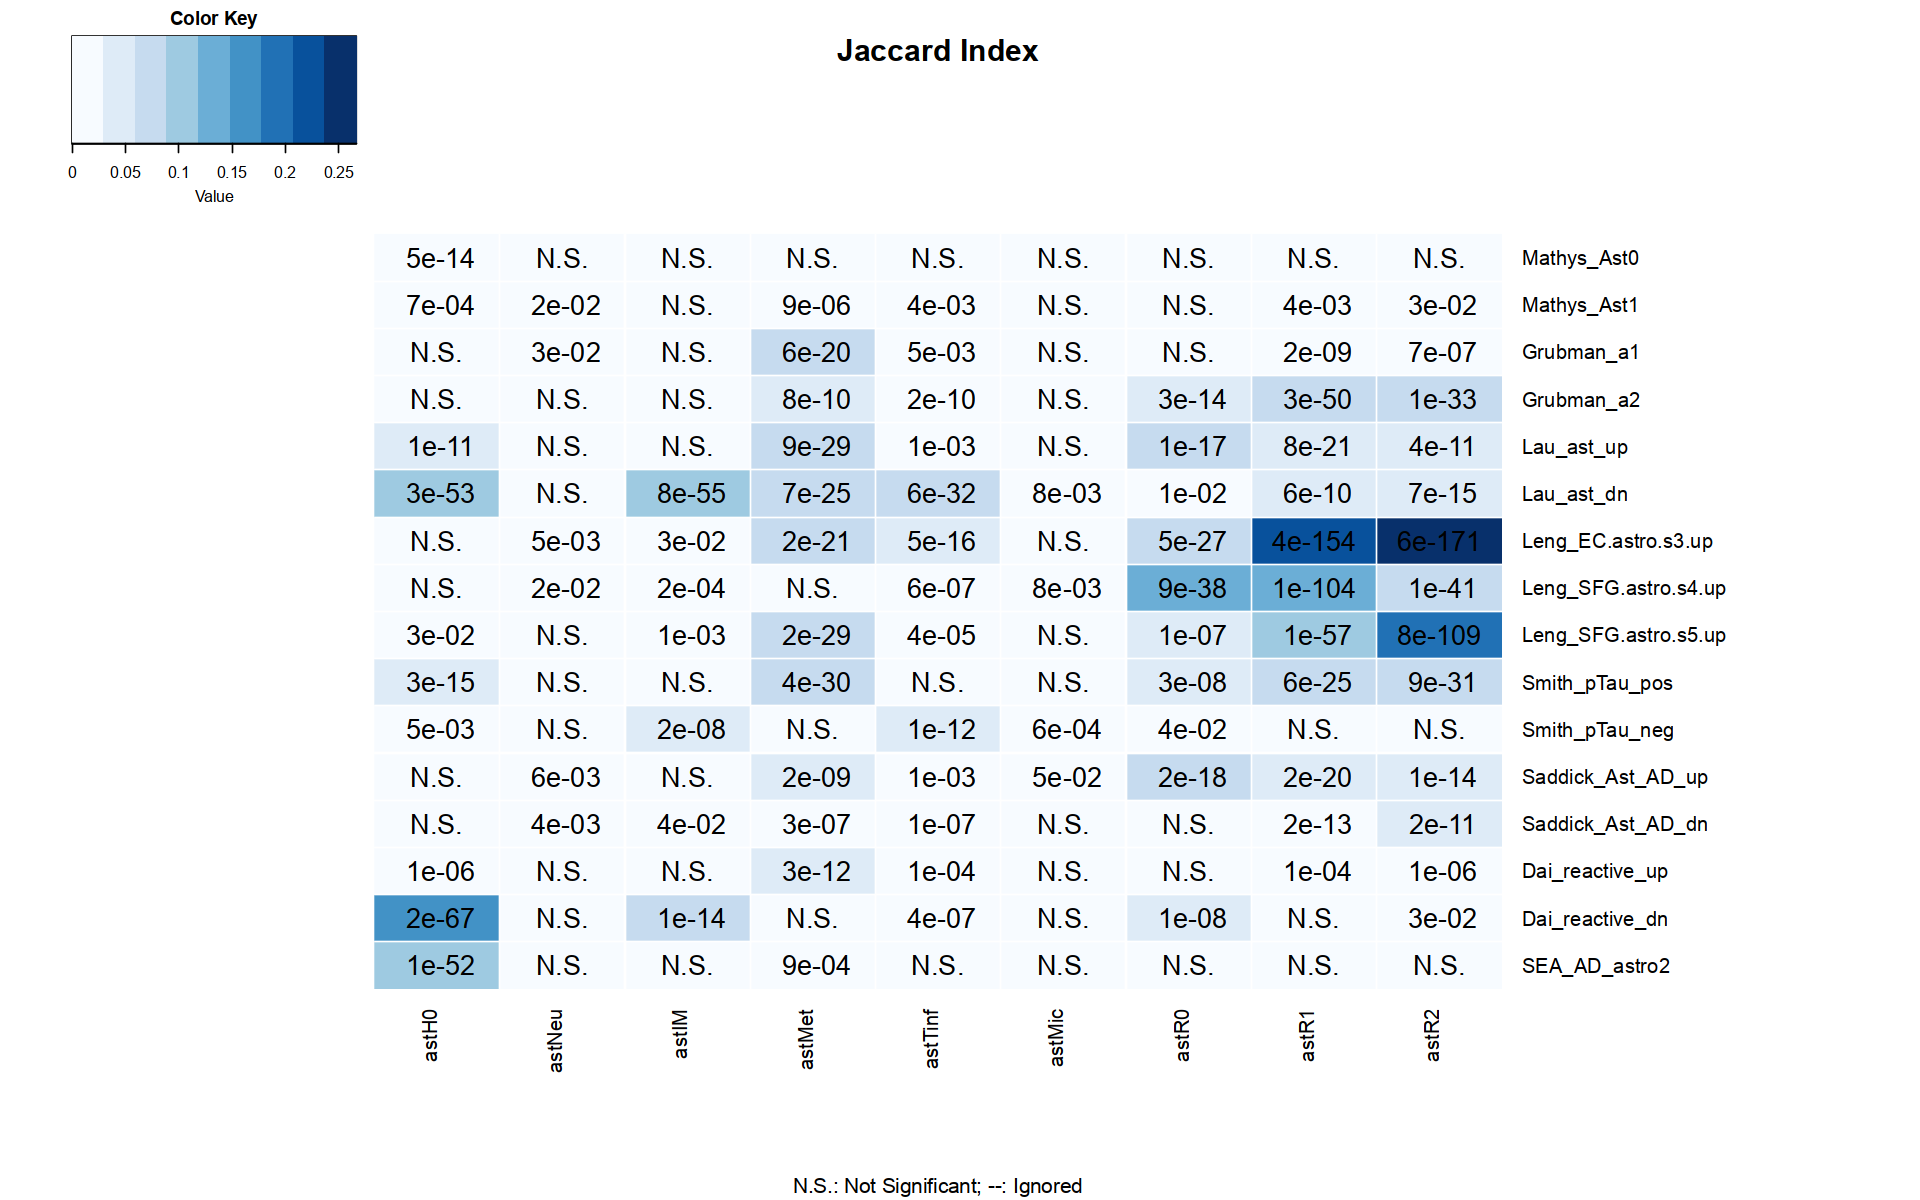

In [52]:
par(family = "Arial")
options(repr.plot.height = 10, repr.plot.width = 16)
drawHeatmap(gom.obj, adj.p=T, cutoff = 0.05, grid.col='Blues', 
            note.col = 'black', #rgb(0, 0, 0, 0, names = NULL, maxColorValue = 1), 
            what="Jaccard", log.scale=F) #what="odds.ratio", 